In [9]:
import numpy as np
import neurokit2 as nk
from scipy import integrate
import pickle
import pandas as pd
import numpy as np

# acceleration
def acc(speed, time):
    return np.gradient(speed, time, edge_order=2)

# motion sickness dose value
def msdv_eq(speed, time):
    return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))

# peaks
def find_peaks(gsr):
    decomposed_eda = nk.eda_process(gsr, sampling_rate=4)[0]
    eda_interval = nk.eda_intervalrelated(decomposed_eda, sampling_rate=4)
    num_of_peaks = eda_interval["SCR_Peaks_N"]
    return sum(num_of_peaks)

# load data
data_path = './data/raw_data2020.p'
dataPoolfont_sizefont_size = pickle.load(open(data_path, "rb"))

num_of_samples = len(list(dataPoolfont_sizefont_size.keys()))
# num_of_samples = 1
num_of_interval = 30

figsize = (15, 10)

input_list = []
output_list = []

for j in range(num_of_samples):
    name = list(dataPoolfont_sizefont_size.keys())[j]
    one_sample = dataPoolfont_sizefont_size[name]
    time_speed = one_sample.Steam.rawSpeed.Time
    raw_speed = one_sample.Steam.rawSpeed.Speed
    GSR = one_sample.Empatica.GSR
    time_eda = one_sample.Empatica.GSR.Time
    one_sample_input = []
    one_sample_output = []
    
    # adjust time scale
    t = np.arange(0, 0.25*len(GSR), 0.25)
    t_difference = t[-1] - time_speed.iloc[-1]
    if t_difference >= 0:
        countTimeInZero = int(t_difference/0.25)
        timeBase = t[countTimeInZero]
        t -= timeBase
    GSR.E4_Time = t
    GSR = GSR.drop(GSR[GSR.E4_Time < 0].index)
    GSR.reset_index(drop=True, inplace=True)
    
    # Peaks
    # method = neurokit / biosppy
    decomposed_eda = nk.eda_process(GSR.GSR, sampling_rate=4)[0]
    step = int(len(GSR.GSR) / num_of_interval)
    peaks_list = []
    piece_gsr = []
    for i in range(0, len(GSR.GSR), step):
        if len(GSR.GSR[i: i+step]) < step:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i-step:], 
                                                  sampling_rate=4)
            peaks_list[-1] = eda_interval["SCR_Peaks_N"].values
            piece_gsr[-1] = decomposed_eda["EDA_Raw"][i-step:].values
            # piece_gsr[-1] = decomposed_eda["EDA_Phasic"][i-step:].values
        else:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i: i+step], 
                                                  sampling_rate=4)
            peaks_list.append(eda_interval["SCR_Peaks_N"].values)
            piece_gsr.append(decomposed_eda["EDA_Raw"][i: i+step].values)
            # piece_gsr.append(decomposed_eda["EDA_Phasic"][i: i+step].values)

    # MSDV
    msdv_list = []
    step = int(len(time_speed) / num_of_interval)
    speed_list = []
    for i in range(0, len(raw_speed), step):
        if len(raw_speed[i: i+step]) < step:
            speed_list[-1] = raw_speed[i-step:].values
            msdv_list[-1] = msdv_eq(raw_speed[i-step:], time_speed[i-step:])
        else:
            speed_list.append(raw_speed[i: i+step].values)
            msdv_list.append(msdv_eq(raw_speed[i: i+step], time_speed[i: i+step]))
    
    input_list.append([name, speed_list, piece_gsr]) # INPUT
    output_list.append([name, msdv_list, peaks_list]) # OUTPUT

merged_input_list = []
merged_output_list = []
for i in range(num_of_samples):
    # remove group name
    input_list[i][0] = input_list[i][0].split("group")[0]
    input_list[i][0] = input_list[i][0].split("gift")[0]
    output_list[i][0] = output_list[i][0].split("group")[0]
    output_list[i][0] = output_list[i][0].split("gift")[0]
# merge info
skip_step, pivot = 0, 0
for i in range(num_of_samples):
    name = input_list[pivot][0]
    tmp_speed = input_list[pivot][1]
    tmp_gsr = input_list[pivot][2]
    tmp_msdv = output_list[pivot][1]
    tmp_peaks = output_list[pivot][2]
    matched = False
    for j in range(pivot+1, num_of_samples, 1):
        if name == input_list[j][0]:
            tmp_speed = tmp_speed + input_list[j][1]
            tmp_gsr = tmp_gsr + input_list[j][2]
            tmp_msdv = tmp_msdv + output_list[j][1]
            tmp_peaks = tmp_peaks + output_list[j][2]
            skip_step = j
            matched = True
    merged_input_list.append([name, tmp_speed, tmp_gsr])
    merged_output_list.append([name, tmp_msdv, tmp_peaks])
    if matched:
        pivot = skip_step+1
    else:
        pivot += 1
    if pivot >= num_of_samples:
        break

# file_name = './peaks/data0_BingHan4.txt'
# with open(file_name, 'wb') as fp:
#     pickle.dump(merged_output_list[4][2], fp)

file_name = 'input.txt'
with open(file_name, 'wb') as fp:
    pickle.dump(merged_input_list, fp)


/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_94944/3559685774.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_94944/3559685774.py:14: De

In [10]:
# 初始化一个空列表来存储所有的 average 值
all_averages = []

# 记录所有的 average 值
for index in range(53):  # 包括 0 到 52
    length = len(merged_input_list[index][1])
    for i in range(length):
        # 计算每个样本的 average 值
        average = np.mean(merged_input_list[index][2][i])
        all_averages.append(average)

# 将所有的 average 值转为 numpy 数组
all_averages = np.array(all_averages)

# 计算10%、20%、...、90%的分位点
percentiles = [5, 20, 30, 40, 50, 60, 70, 80, 90]
boundaries = np.percentile(all_averages, percentiles)

print("Boundary values (percentiles):", boundaries)

Boundary values (percentiles): [0.06593224 0.22635852 0.49723496 1.52497042 2.44425655 3.57594897
 4.75210448 6.36503633 9.66126052]


In [11]:
# 使用这些 boundary 值来设置 sickness_level
for index in range(53):  # 包括 0 到 52
    action, msdv, sickness_level = [], [], []
    
    length = len(merged_input_list[index][1])
    for i in range(length):
        # 计算 average
        average = np.mean(merged_input_list[index][2][i])
        
        # 根据 boundary 设置 sickness_level
        if average <= boundaries[0]:
            sickness_level.append(0.1)
        elif boundaries[0] < average <= boundaries[1]:
            sickness_level.append(0.2)
        elif boundaries[1] < average <= boundaries[2]:
            sickness_level.append(0.3)
        elif boundaries[2] < average <= boundaries[3]:
            sickness_level.append(0.4)
        elif boundaries[3] < average <= boundaries[4]:
            sickness_level.append(0.5)
        elif boundaries[4] < average <= boundaries[5]:
            sickness_level.append(0.6)
        elif boundaries[5] < average <= boundaries[6]:
            sickness_level.append(0.7)
        elif boundaries[6] < average <= boundaries[7]:
            sickness_level.append(0.8)
        else:
            sickness_level.append(0.9)

In [15]:
import numpy as np
import scipy.io

# 初始化存储所有index的数据列表
all_actions = []
all_msdv = []
all_sickness_levels = []

# 定义边界条件 王老师的分法
# bound = [1, 0.8, 0.1, 2.5, 4]
# 我suggest一个新的分类方法 提升类别的数量，然后一定程度帮助到图像的可视化 （定义从 0 到 4 均匀分成 9 份的边界）

bound = np.linspace(0, 4, 10)  # 包含 10 个边界点（包括 0 和 4）




# 遍历每个index
for index in range(53):  # 包括 0 到 52
    action, msdv, sickness_level = [], [], []
    
    length = len(merged_input_list[index][1])
    for i in range(length):
        # speed <=> action
        if np.mean(merged_input_list[index][1][i]) < bound[0]:
            action.append(0)
        else:
            action.append(1)
        
        # msdv <=> reward 
        if np.mean(merged_output_list[index][1][i]) < bound[1]:
            msdv.append(0)
        else:
            msdv.append(1)
        
        # true sickness level
        average = np.mean(merged_input_list[index][2][i])
        
        # 根据 boundary 设置 sickness_level
        if average <= boundaries[0]:
            sickness_level.append(0.1)
        elif boundaries[0] < average <= boundaries[1]:
            sickness_level.append(0.2)
        elif boundaries[1] < average <= boundaries[2]:
            sickness_level.append(0.3)
        elif boundaries[2] < average <= boundaries[3]:
            sickness_level.append(0.4)
        elif boundaries[3] < average <= boundaries[4]:
            sickness_level.append(0.5)
        elif boundaries[4] < average <= boundaries[5]:
            sickness_level.append(0.6)
        elif boundaries[5] < average <= boundaries[6]:
            sickness_level.append(0.7)
        elif boundaries[6] < average <= boundaries[7]:
            sickness_level.append(0.8)
        else:
            sickness_level.append(0.9)

    action = np.double(action)
    msdv = np.double(msdv)
    
    # 将当前 index 的数据添加到总列表中
    all_actions.append(action)
    all_msdv.append(msdv)
    all_sickness_levels.append(sickness_level)

# 将所有 index 的数据打包为字典
Data_0 = {'action': all_actions, 'reward': all_msdv}
Data = {"level": all_sickness_levels}



In [113]:
len(Data['level'][3])

90

In [106]:
anne_data = df_output[df_output['tester'] == 'Anne']

2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: tmp_msdv, dtype: object

In [3]:
import pandas as pd
import numpy as np
df_output = pd.DataFrame(merged_output_list,columns=['tester', 'tmp_msdv', 'peaks'])
df_output

tester                                           tmp_msdv  \
0      Andreas  [[0.0, 10.235038632014964, 14.073332389627016,...   
1       Anjela  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2         Anne  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3         Aron  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4      BingHan  [[0.0, 3.154252773752122, 3.7037348249875524, ...   
5        Bowen  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6     Chenyang  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
7        Cunbo  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8        Danfo  [[0.0, 6.530872954118741, 7.6432728994553365, ...   
9       Emilio  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
10    Fangnian  [[0.0, 16.381116375499364, 19.09772470011626, ...   
11  FelixLonge  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
12     Guanzhi  [[0.0, 1.8593046656969348, 2.294199748025825, ...   
13     Haoming  [[0.0, 2.610285958515914, 4.065858806996298, 4...   
14     Haoyang  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
15     Hongmin  [[0.0, 4.405043385006301, 5.306568548845895, 5...   
16     HuanQin  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
17       JiaYu  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
18     Jieyang  [[0.0, 6.10071683582961, 6.940721777334437, 6....   
19      Jingsi  [[0.0, 5.968431967692658, 6.930264364742764, 6...   
20    Jingting  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
21     Johanna  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
22    Juliette  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
23     Junming  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
24       KeCao  [[0.0, 0.18999923961154744, 0.2266142662139010...   
25         Lea  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
26    Lingfeng  [[0.0, 6.606419656056391, 7.645302712377869, 7...   
27      LiuWan  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
28       Lukas  [[0.0, 7.181643568836435, 8.120224947572618, 8...   
29     Meihang  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
30        Mila  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
31     Minghui  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
32        Olaf  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
33      Qiansi  [[0.0, 8.33311820222724, 11.071528868210427, 1...   
34      Qichen  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
35       Ramon  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
36   Shaoxiang  [[0.0, 5.19593962664563, 5.976364180724602, 5....   
37        Theo  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
38      Tianci  [[0.0, 2.2413593535961778, 2.5793748696145506,...   
39      Wenjun  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
40      Wenzhe  [[0.0, 6.87427349494672, 7.847819117457631, 7....   
41    Xianfeng  [[0.0, 0.661791084086609, 0.7916839702238172, ...   
42      XinZhu  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
43      Xinrui  [[0.0, 5.2947236669874, 6.247554662470817, 6.2...   
44       YanZu  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
45       YiLuo  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
46        Yibo  [[0.0, 4.230457690257183, 4.962328643170187, 4...   
47       Yiwei  [[0.0, 5.274555998112107, 6.118803132906393, 6...   
48     Yuemiao  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
49       Yujia  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
50       Zheli  [[0.0, 7.659168969289104, 9.419350053890476, 9...   
51     Zhilong  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
52       Zihan  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
53     Zunchao  [[0.0, 8.817546308444935, 9.957523785035741, 9...   

                                                peaks  
0   [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [2....  
1   [[0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1....  
2   [[4.0], [7.0], [5.0], [4.0], [6.0], [4.0

In [29]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem

In [30]:
# Extract Andreas' data
andreas_data = df_output[df_output['tester'] == 'Andreas']
MSDV = np.array(andreas_data['tmp_msdv'])
GSR = np.array(andreas_data['peaks'])
sickness = np.array(Data['level'][0])  # Assuming this is how sickness score is stored


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 49 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


IndexError: list index out of range

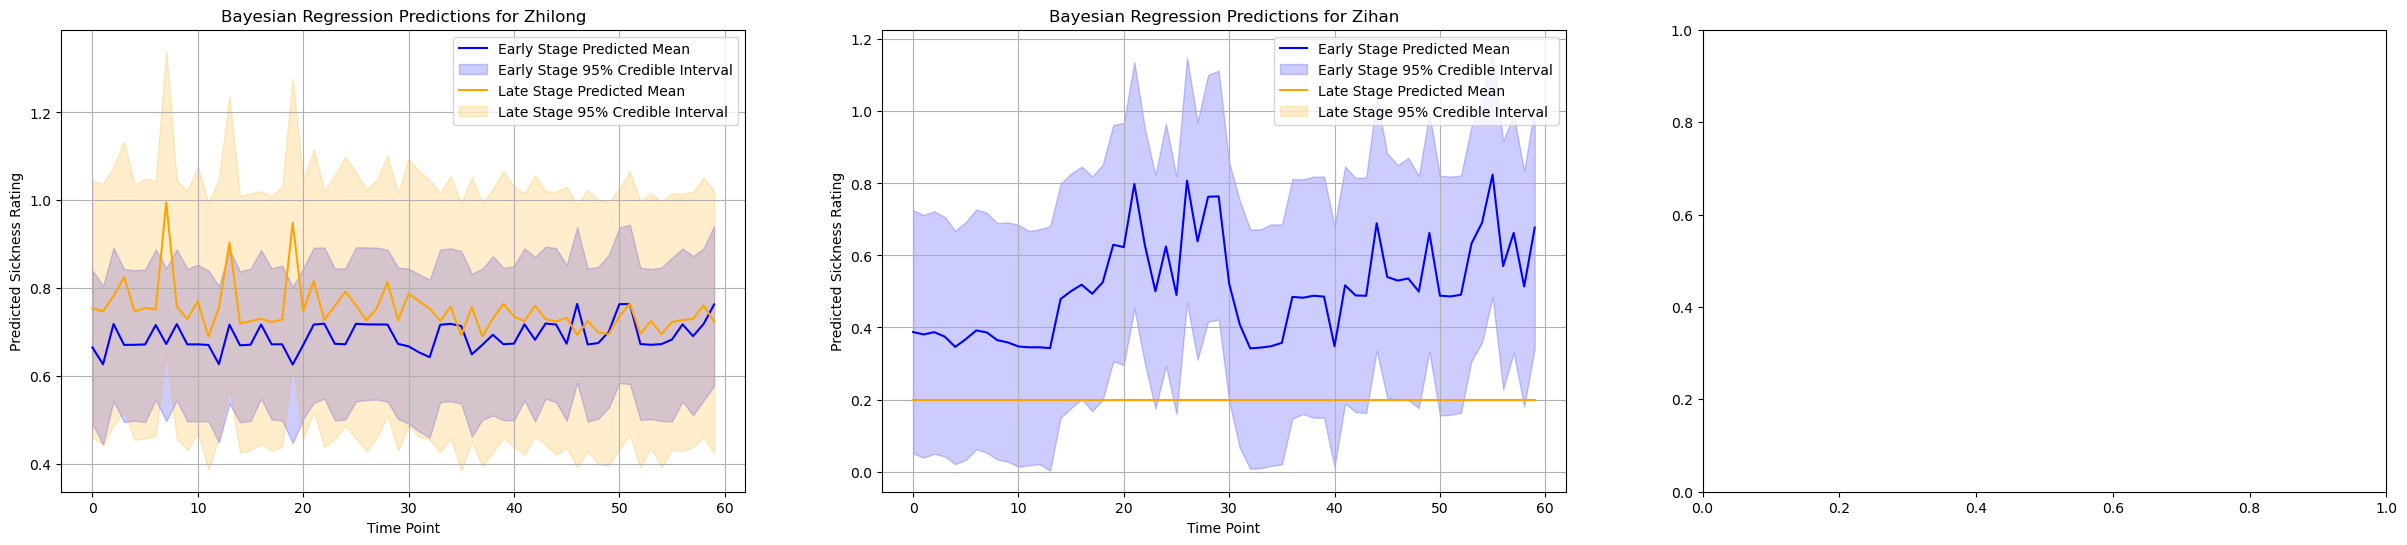

In [119]:
import os
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# 创建保存图表的文件夹
output_folder = "lab3"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def bayesian_regression(MSDV_mean, peak_mean, sickness):
    with pm.Model() as model:
        # Coefficients with priors
        beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
        beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
        beta_2 = pm.Normal("beta_2", mu=0, sigma=10)
        
        # Likelihood
        mu = beta_0 + beta_1 * MSDV_mean + beta_2 * peak_mean
        sigma = pm.HalfNormal("sigma", sigma=1)
        
        # Observations
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=sickness)
        
        # Posterior sampling
        trace = pm.sample(2000, return_inferencedata=False)
        
        # Posterior predictive
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['y_obs'], random_seed=42)
    
    # 获取预测均值和95%可信区间
    y_obs_pred = posterior_predictive['posterior_predictive']['y_obs']
    pred_mean = np.mean(y_obs_pred, axis=(0, 1))  # Average over chain and draw dimensions
    pred_ci = np.percentile(y_obs_pred, [2.5, 97.5], axis=(0, 1))
    
    return pred_mean, pred_ci

def process_participant(participant_name, participant_index, ax):
    participant_data = df_output[df_output['tester'] == participant_name]

    # 提取 tmp_msdv 和 peaks，直接使用 .iloc[0]
    MSDV_groups = participant_data['tmp_msdv'].iloc[0]  # 提取实际数据
    peak_groups = participant_data['peaks'].iloc[0]     # 提取实际数据

    # 计算每个组的平均值，尽管这些组的长度不同
    MSDV_mean = np.array([np.mean(group) for group in MSDV_groups])
    peak_mean = np.array([np.mean(group) for group in peak_groups])

    # 假设 sickness 分数在 Data['level'][participant_index]，并确保它是 1D 数组
    sickness = np.array(Data['level'][participant_index])

    # 将数据分为前一半和后一半
    mid_point = len(sickness) // 2
    early_MSDV_mean = MSDV_mean[:mid_point]
    late_MSDV_mean = MSDV_mean[mid_point:]
    early_peak_mean = peak_mean[:mid_point]
    late_peak_mean = peak_mean[mid_point:]
    early_sickness = sickness[:mid_point]
    late_sickness = sickness[mid_point:]

    # Early stage Bayesian regression
    early_pred_mean, early_pred_ci = bayesian_regression(early_MSDV_mean, early_peak_mean, early_sickness)

    # Late stage Bayesian regression
    late_pred_mean, late_pred_ci = bayesian_regression(late_MSDV_mean, late_peak_mean, late_sickness)

    # 绘制结果在指定的轴上
    ax.plot(range(mid_point), early_pred_mean, label='Early Stage Predicted Mean', color='blue')
    ax.fill_between(range(mid_point), early_pred_ci[0], early_pred_ci[1], color='blue', alpha=0.2, label='Early Stage 95% Credible Interval')

    ax.plot(range(mid_point), late_pred_mean, label='Late Stage Predicted Mean', color='orange')
    ax.fill_between(range(mid_point), late_pred_ci[0], late_pred_ci[1], color='orange', alpha=0.2, label='Late Stage 95% Credible Interval')

    ax.set_xlabel('Time Point')
    ax.set_ylabel('Predicted Sickness Rating')
    ax.set_title(f'Bayesian Regression Predictions for {participant_name}')
    ax.legend()
    ax.grid(True)

# 生成图表并保存
participants = df_output['tester'].unique()

# 将参与者分组，每三人一行展示并保存
for i in range(0, len(participants), 3):
    fig, axs = plt.subplots(1, 3, figsize=(30, 6))  # 一行三列的布局
    for j, participant in enumerate(participants[i:i+3]):
        process_participant(participant, i + j, axs[j])
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f'group_{i//3 + 1}_bayesian_regression.png'))
    plt.close(fig)

print(f"All plots have been saved to the '{output_folder}' folder.")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 55 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


KeyboardInterrupt: 

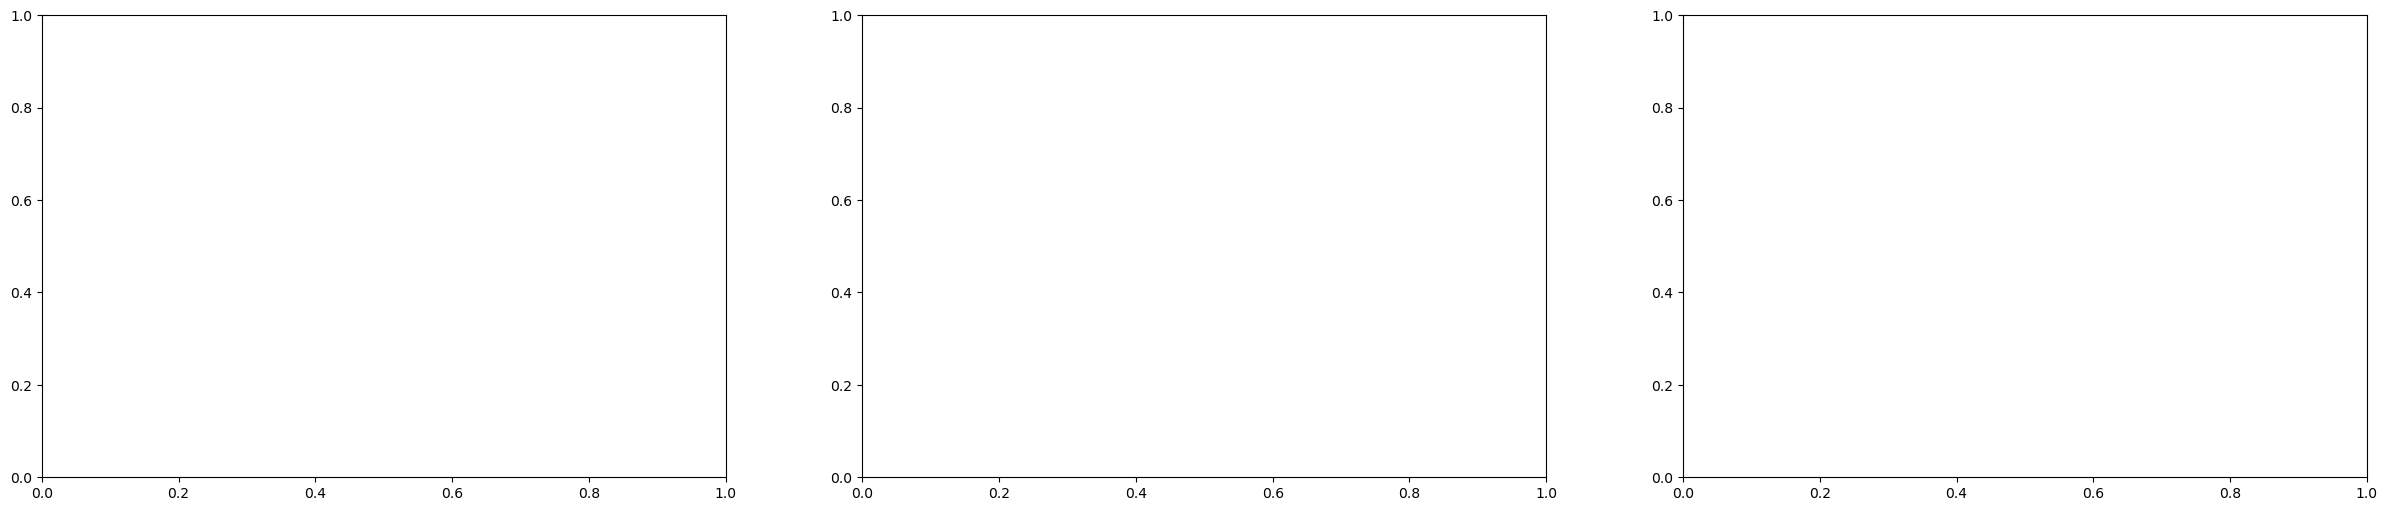

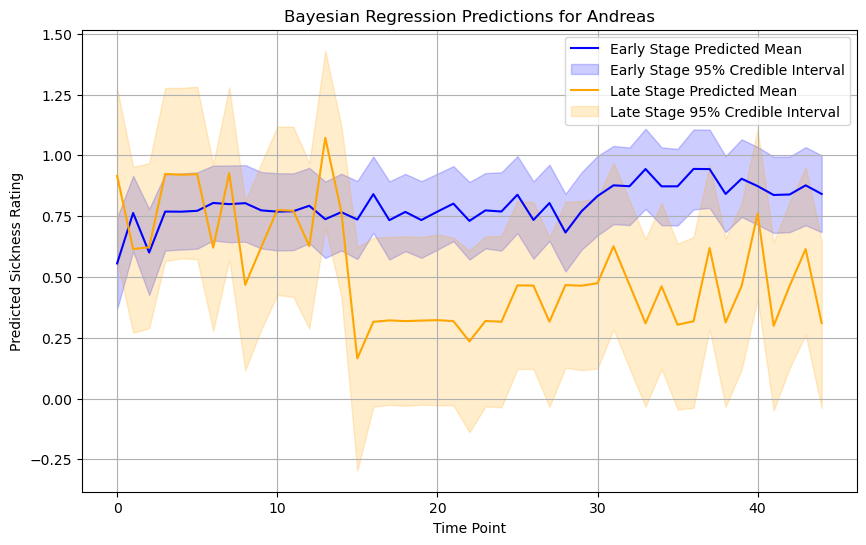

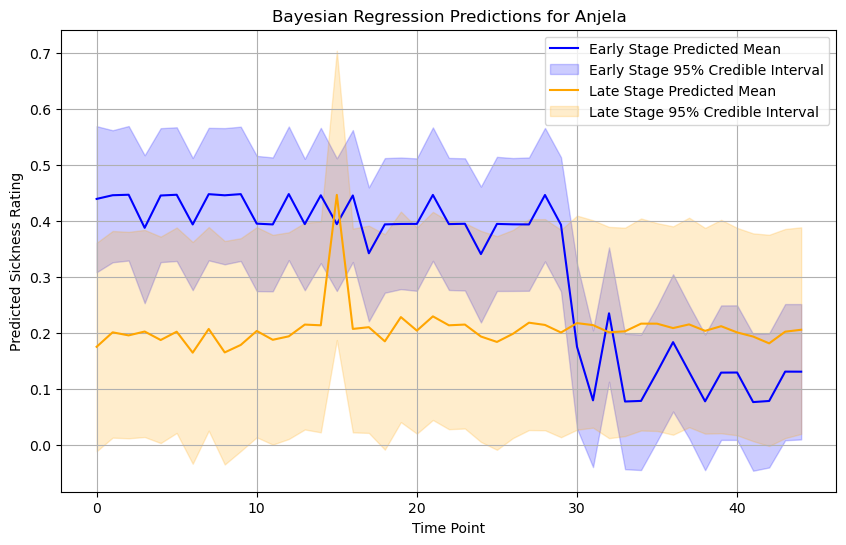

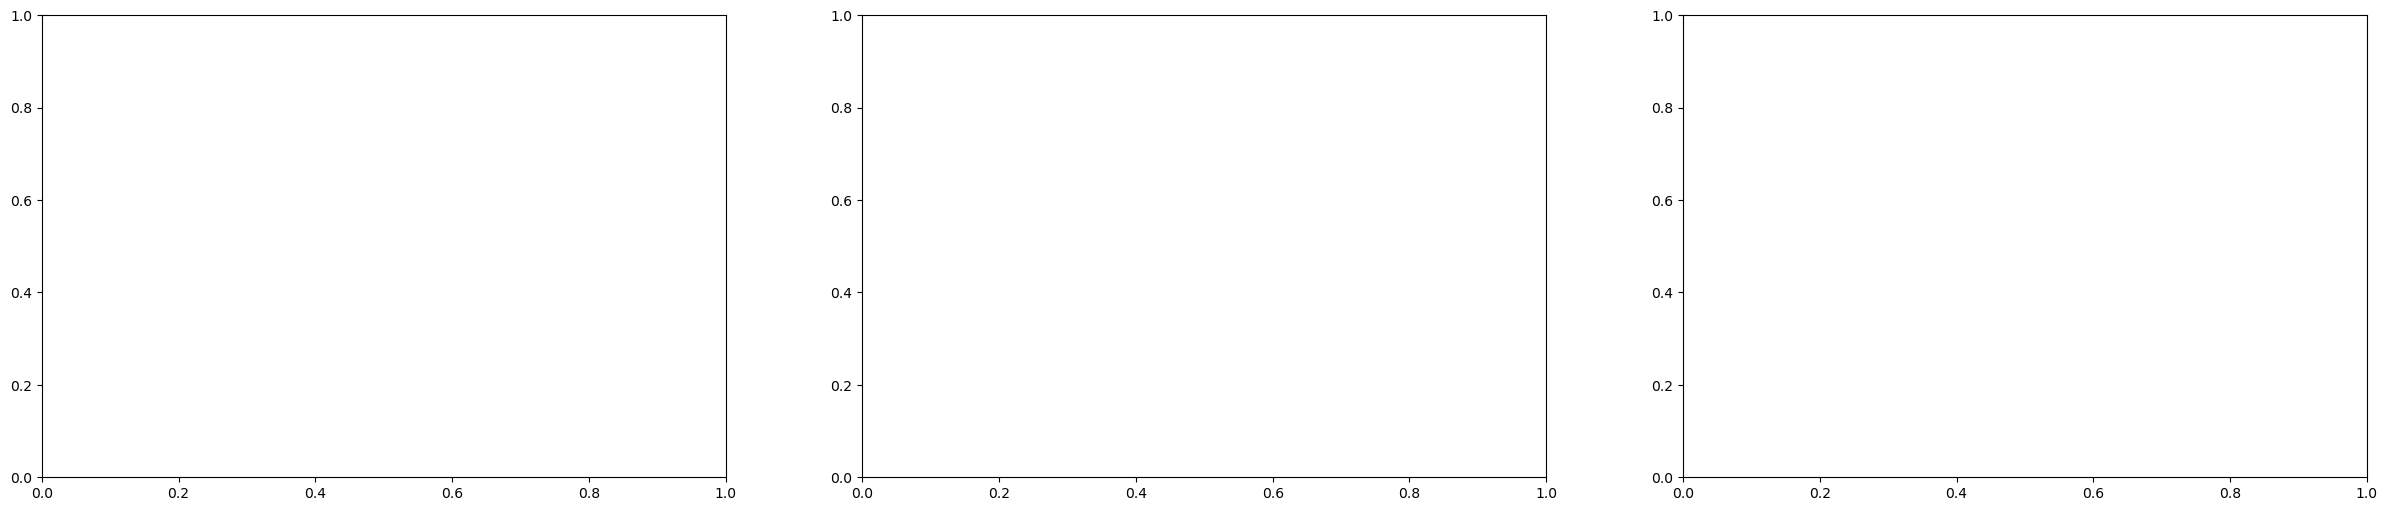

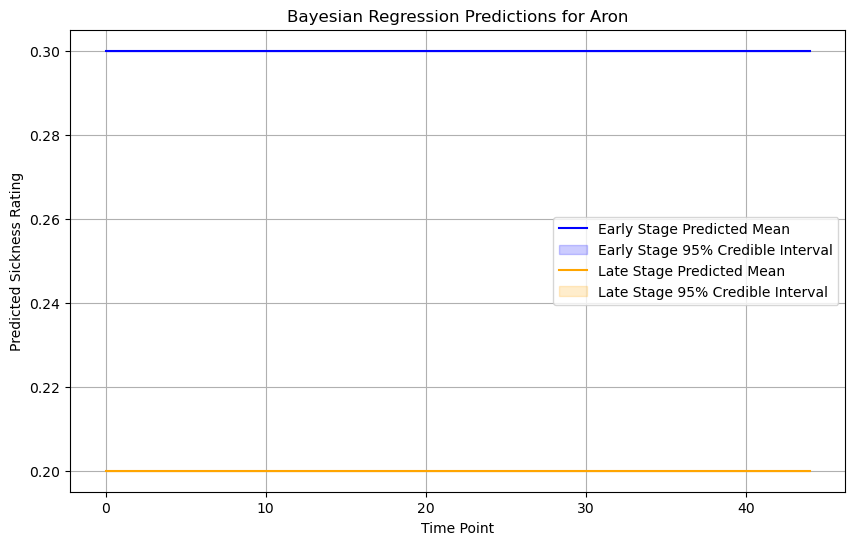

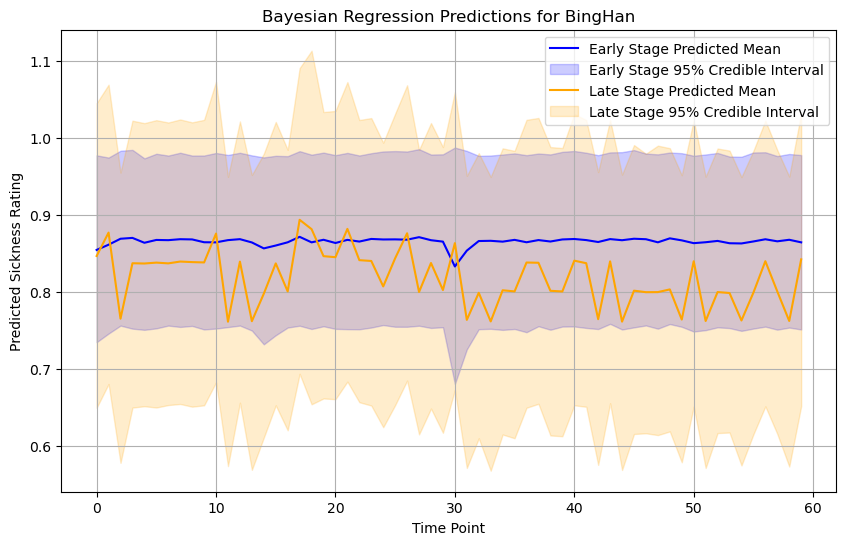

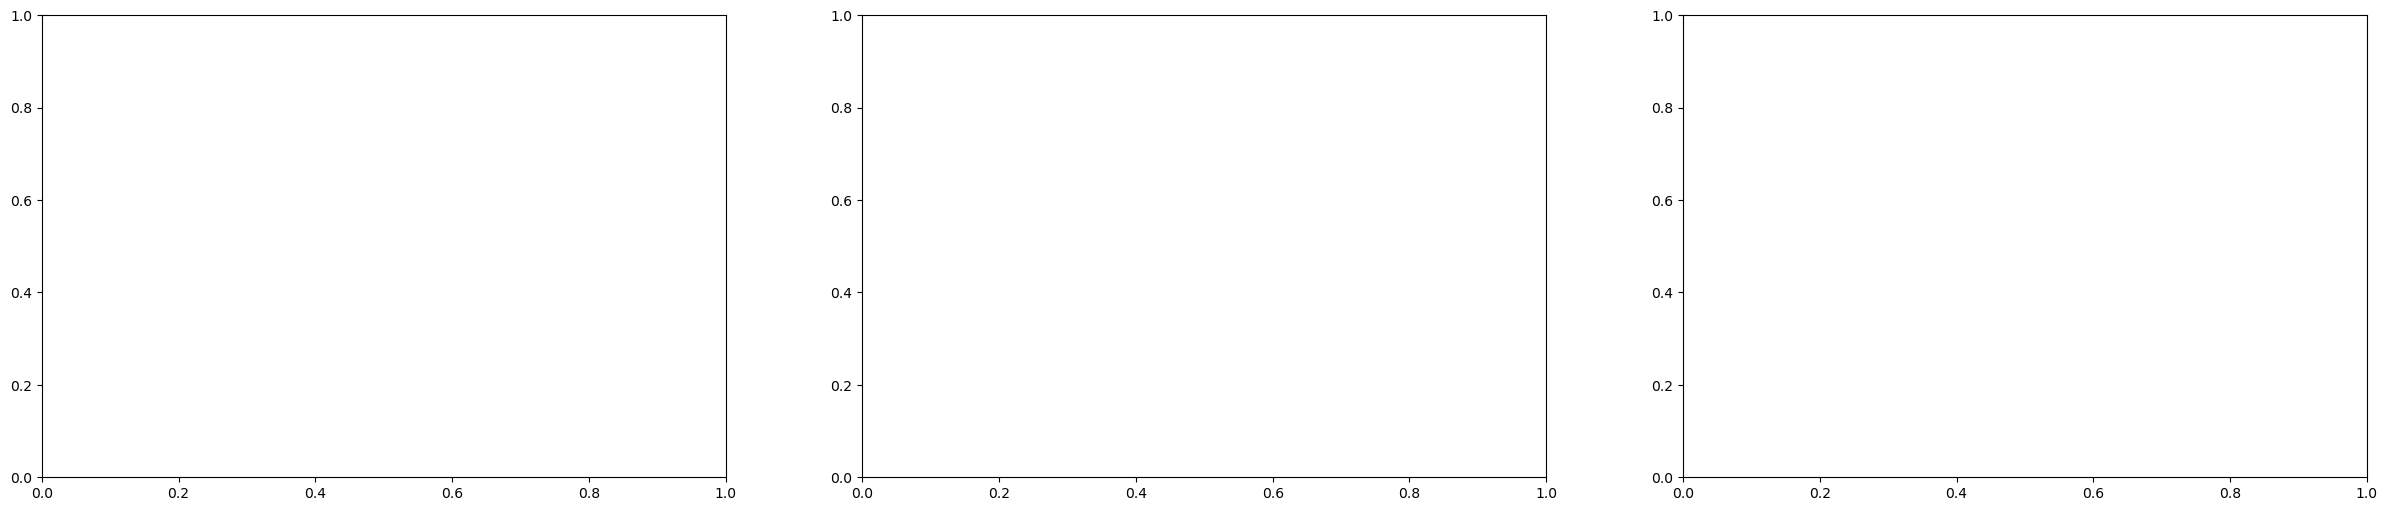

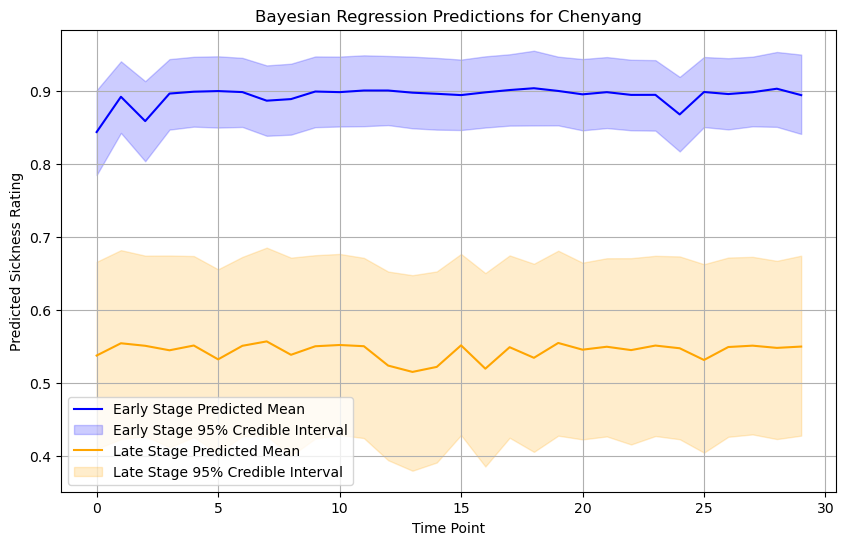

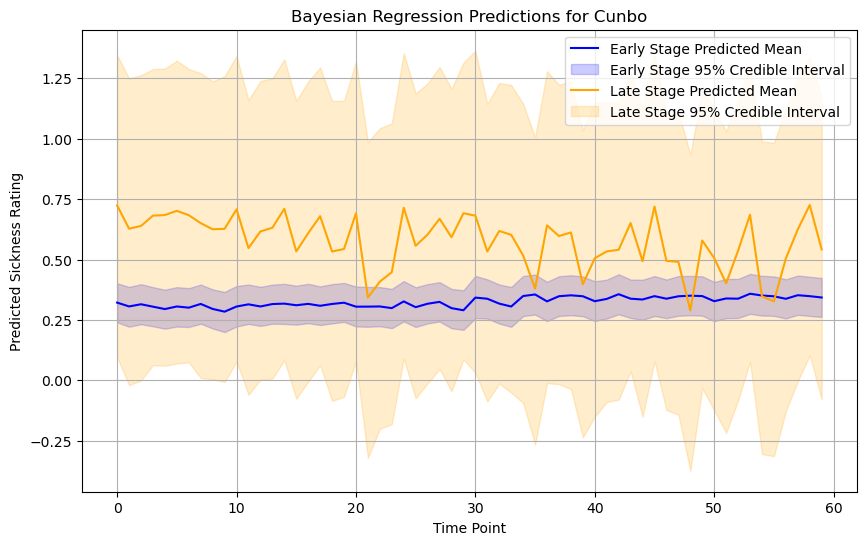

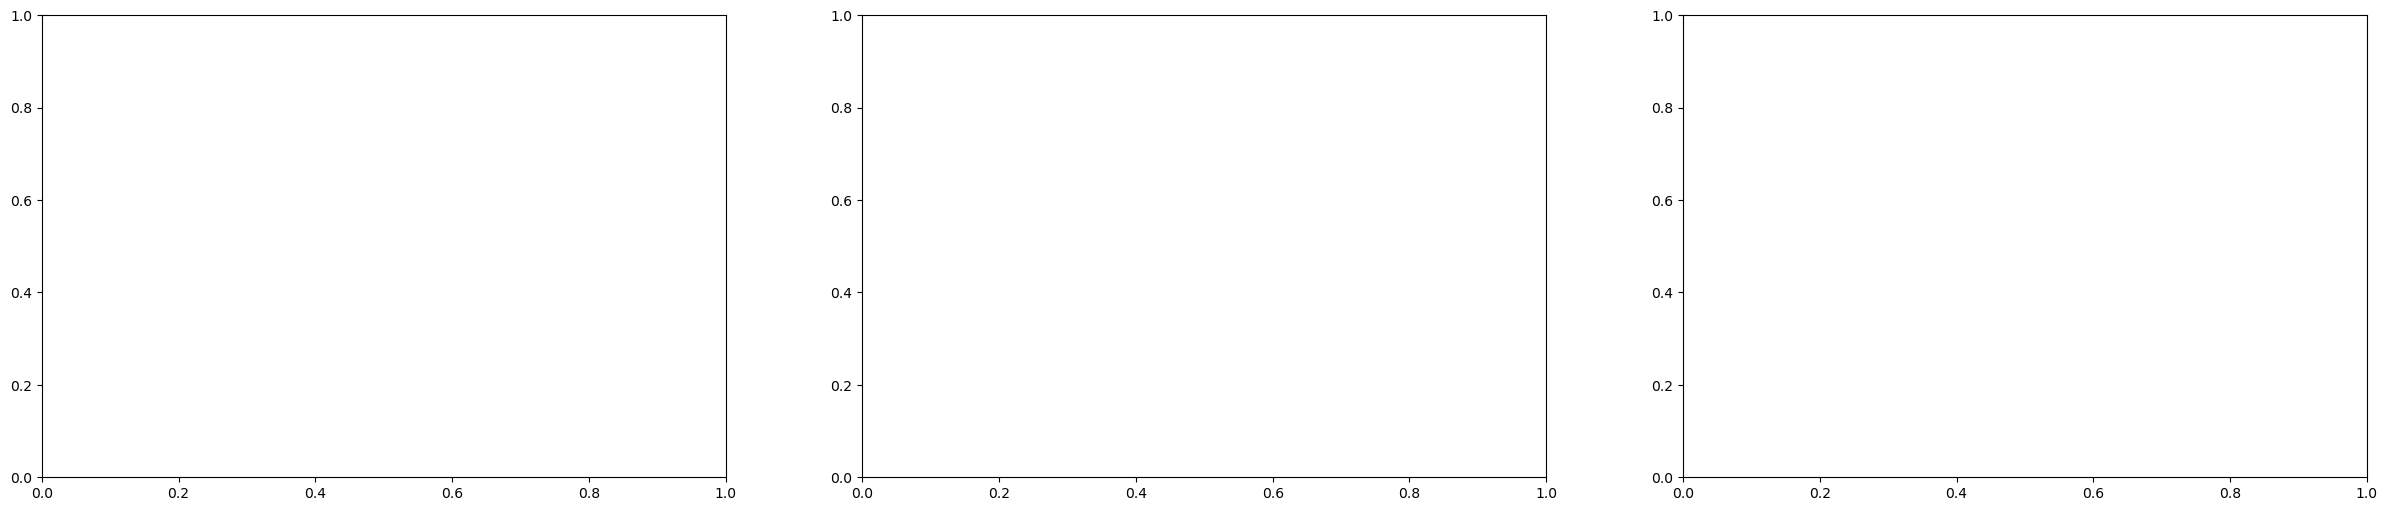

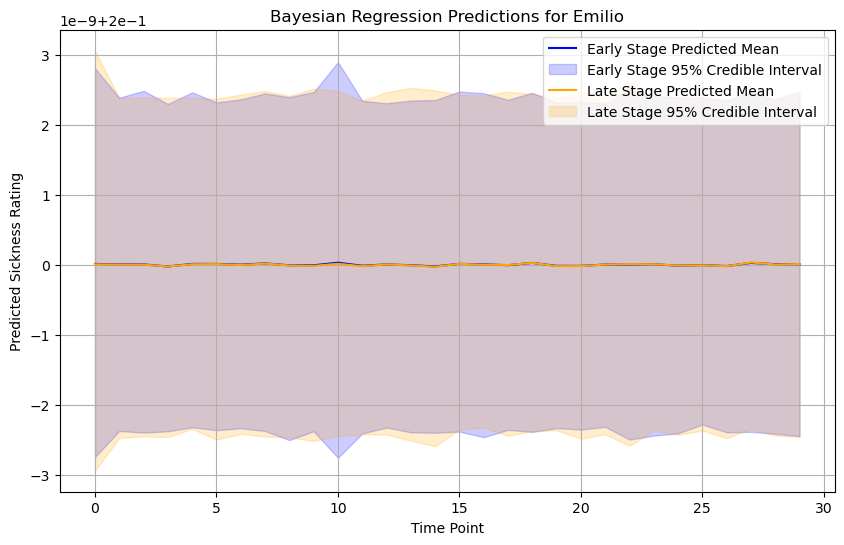

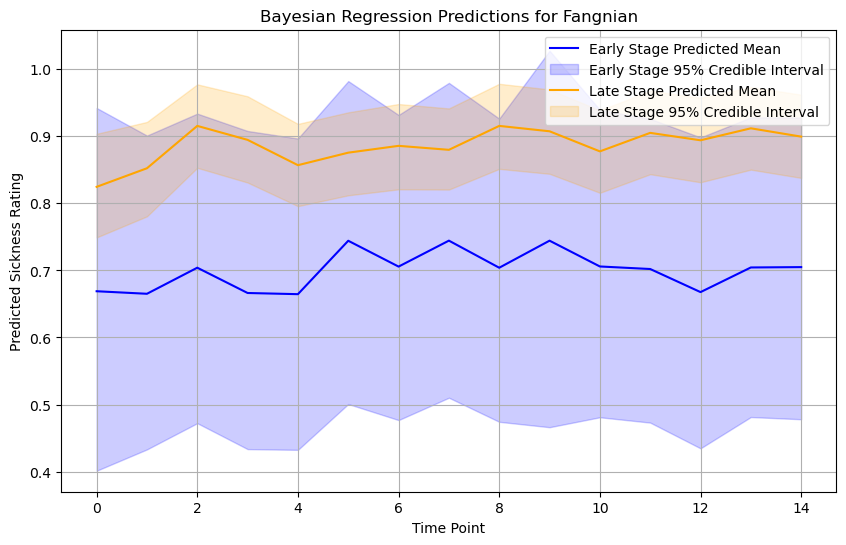

In [116]:
import os
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# 创建保存图表的文件夹
output_folder = "lab3"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def bayesian_regression(MSDV_mean, peak_mean, sickness):
    with pm.Model() as model:
        # Coefficients with priors
        beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
        beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
        beta_2 = pm.Normal("beta_2", mu=0, sigma=10)
        
        # Likelihood
        mu = beta_0 + beta_1 * MSDV_mean + beta_2 * peak_mean
        sigma = pm.HalfNormal("sigma", sigma=1)
        
        # Observations
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=sickness)
        
        # Posterior sampling
        trace = pm.sample(2000, return_inferencedata=False)
        
        # Posterior predictive
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['y_obs'], random_seed=42)
    
    # 获取预测均值和95%可信区间
    y_obs_pred = posterior_predictive['posterior_predictive']['y_obs']
    pred_mean = np.mean(y_obs_pred, axis=(0, 1))  # Average over chain and draw dimensions
    pred_ci = np.percentile(y_obs_pred, [2.5, 97.5], axis=(0, 1))
    
    return pred_mean, pred_ci

def process_participant(participant_name, participant_index):
    participant_data = df_output[df_output['tester'] == participant_name]

    # 提取 tmp_msdv 和 peaks，直接使用 .iloc[0]
    MSDV_groups = participant_data['tmp_msdv'].iloc[0]  # 提取实际数据
    peak_groups = participant_data['peaks'].iloc[0]     # 提取实际数据

    # 计算每个组的平均值，尽管这些组的长度不同
    MSDV_mean = np.array([np.mean(group) for group in MSDV_groups])
    peak_mean = np.array([np.mean(group) for group in peak_groups])

    # 假设 sickness 分数在 Data['level'][participant_index]，并确保它是 1D 数组
    sickness = np.array(Data['level'][participant_index])

    # 将数据分为前一半和后一半
    mid_point = len(sickness) // 2
    early_MSDV_mean = MSDV_mean[:mid_point]
    late_MSDV_mean = MSDV_mean[mid_point:]
    early_peak_mean = peak_mean[:mid_point]
    late_peak_mean = peak_mean[mid_point:]
    early_sickness = sickness[:mid_point]
    late_sickness = sickness[mid_point:]

    # Early stage Bayesian regression
    early_pred_mean, early_pred_ci = bayesian_regression(early_MSDV_mean, early_peak_mean, early_sickness)

    # Late stage Bayesian regression
    late_pred_mean, late_pred_ci = bayesian_regression(late_MSDV_mean, late_peak_mean, late_sickness)

    # 绘制结果
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制 Early Stage 预测的均值和可信区间
    ax.plot(range(mid_point), early_pred_mean, label='Early Stage Predicted Mean', color='blue')
    ax.fill_between(range(mid_point), early_pred_ci[0], early_pred_ci[1], color='blue', alpha=0.2, label='Early Stage 95% Credible Interval')

    # 绘制 Late Stage 预测的均值和可信区间, 将 x 轴调整到与 Early Stage 一致
    ax.plot(range(mid_point), late_pred_mean, label='Late Stage Predicted Mean', color='orange')
    ax.fill_between(range(mid_point), late_pred_ci[0], late_pred_ci[1], color='orange', alpha=0.2, label='Late Stage 95% Credible Interval')

    ax.set_xlabel('Time Point')
    ax.set_ylabel('Predicted Sickness Rating')
    ax.set_title(f'Bayesian Regression Predictions for {participant_name}')
    ax.legend()
    ax.grid(True)

    return fig

# 生成图表并保存
participants = df_output['tester'].unique()

# 将参与者分组，每三人一行展示并保存
for i in range(0, len(participants), 3):
    fig, axs = plt.subplots(1, 3, figsize=(30, 6))  # 一行三列的布局
    for j, participant in enumerate(participants[i:i+3]):
        fig = process_participant(participant, i + j)
        fig.savefig(os.path.join(output_folder, f'{participant}_bayesian_regression.png'))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f'group_{i//3 + 1}_bayesian_regression.png'))
    plt.close(fig)

print(f"All plots have been saved to the '{output_folder}' folder.")


In [4]:
len(df_output['peaks'][0])

90

In [5]:
len(df_output['tmp_msdv'][0])

90

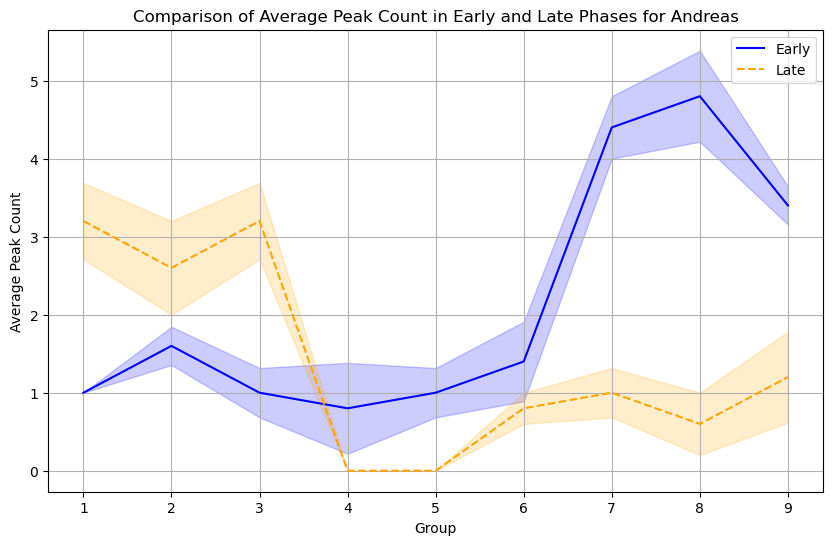

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# 假设 df_output 包含参与者数据
# df_output 格式示例: tester, tmp_msdv, peaks

# 选择参与者Andreas的数据
andreas_data = df_output[df_output['tester'] == 'Andreas']

# 提取峰值数据
peaks = np.array(andreas_data['peaks'].iloc[0])

# 分成前45组和后45组
early_peaks = peaks[:45]
late_peaks = peaks[45:]

# 将45组数据分成9小组，每组5个数据点
def split_into_bins(peaks, num_bins=9):
    bins = np.array_split(peaks, num_bins)
    return bins

early_bins = split_into_bins(early_peaks)
late_bins = split_into_bins(late_peaks)

# 计算每个小组的平均峰值数量和标准误
def calculate_bin_means_and_se(bins):
    means = [np.mean(np.concatenate(bin)) for bin in bins]
    ses = [sem(np.concatenate(bin)) for bin in bins]
    return means, ses

early_means, early_ses = calculate_bin_means_and_se(early_bins)
late_means, late_ses = calculate_bin_means_and_se(late_bins)

# 创建数据框以便于绘图
data = {
    'Phase': ['Early']*9 + ['Late']*9,
    'Group': list(range(1, 10)) + list(range(1, 10)),
    'Mean Peak Count': early_means + late_means,
    'SE': early_ses + late_ses
}
df = pd.DataFrame(data)

# 绘制图表
plt.figure(figsize=(10, 6))

# 早期数据
plt.plot(df[df['Phase'] == 'Early']['Group'], 
         df[df['Phase'] == 'Early']['Mean Peak Count'], 
         label='Early', color='blue')
plt.fill_between(df[df['Phase'] == 'Early']['Group'], 
                 df[df['Phase'] == 'Early']['Mean Peak Count'] - df[df['Phase'] == 'Early']['SE'],
                 df[df['Phase'] == 'Early']['Mean Peak Count'] + df[df['Phase'] == 'Early']['SE'],
                 color='blue', alpha=0.2)

# 晚期数据
plt.plot(df[df['Phase'] == 'Late']['Group'], 
         df[df['Phase'] == 'Late']['Mean Peak Count'], 
         label='Late', color='orange', linestyle='--')
plt.fill_between(df[df['Phase'] == 'Late']['Group'], 
                 df[df['Phase'] == 'Late']['Mean Peak Count'] - df[df['Phase'] == 'Late']['SE'],
                 df[df['Phase'] == 'Late']['Mean Peak Count'] + df[df['Phase'] == 'Late']['SE'],
                 color='orange', alpha=0.2)

plt.xlabel('Group')
plt.ylabel('Average Peak Count')
plt.title('Comparison of Average Peak Count in Early and Late Phases for Andreas')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# 假设 df_output 包含所有受试者的数据
# 创建保存图表的文件夹
output_folder = "lab3"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 定义一个函数来生成图表并保存
def create_and_save_plot(participant_data, participant_name):
    # 提取峰值数据
    peaks = np.array(participant_data['peaks'].iloc[0])

    # 分成前45组和后45组
    early_peaks = peaks[:45]
    late_peaks = peaks[45:]

    # 将45组数据分成9小组，每组5个数据点
    def split_into_bins(peaks, num_bins=9):
        bins = np.array_split(peaks, num_bins)
        return bins

    early_bins = split_into_bins(early_peaks)
    late_bins = split_into_bins(late_peaks)

    # 计算每个小组的平均峰值数量和标准误
    def calculate_bin_means_and_se(bins):
        means = []
        ses = []
        for bin in bins:
            if len(bin) > 0:  # 确保bin中有数据
                concatenated_bin = np.concatenate(bin)
                means.append(np.mean(concatenated_bin))
                ses.append(sem(concatenated_bin))
            else:
                means.append(np.nan)
                ses.append(np.nan)
        return means, ses

    early_means, early_ses = calculate_bin_means_and_se(early_bins)
    late_means, late_ses = calculate_bin_means_and_se(late_bins)

    # 创建数据框以便于绘图
    data = {
        'Phase': ['Early']*9 + ['Late']*9,
        'Group': list(range(1, 10)) + list(range(1, 10)),
        'Mean Peak Count': early_means + late_means,
        'SE': early_ses + late_ses
    }
    df = pd.DataFrame(data)

    # 绘制图表
    plt.figure(figsize=(10, 6))

    # 早期数据
    plt.plot(df[df['Phase'] == 'Early']['Group'], 
             df[df['Phase'] == 'Early']['Mean Peak Count'], 
             label='Early', color='blue')
    plt.fill_between(df[df['Phase'] == 'Early']['Group'], 
                     df[df['Phase'] == 'Early']['Mean Peak Count'] - df[df['Phase'] == 'Early']['SE'],
                     df[df['Phase'] == 'Early']['Mean Peak Count'] + df[df['Phase'] == 'Early']['SE'],
                     color='blue', alpha=0.2)

    # 晚期数据
    plt.plot(df[df['Phase'] == 'Late']['Group'], 
             df[df['Phase'] == 'Late']['Mean Peak Count'], 
             label='Late', color='orange', linestyle='--')
    plt.fill_between(df[df['Phase'] == 'Late']['Group'], 
                     df[df['Phase'] == 'Late']['Mean Peak Count'] - df[df['Phase'] == 'Late']['SE'],
                     df[df['Phase'] == 'Late']['Mean Peak Count'] + df[df['Phase'] == 'Late']['SE'],
                     color='orange', alpha=0.2)

    plt.xlabel('Group')
    plt.ylabel('Average Peak Count')
    plt.title(f'Comparison of Average Peak Count in Early and Late Phases for {participant_name}')
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(os.path.join(output_folder, f'{participant_name}.png'))
    plt.close()

# 遍历所有受试者并生成图表
participants = df_output['tester'].unique()
for participant in participants:
    participant_data = df_output[df_output['tester'] == participant]
    create_and_save_plot(participant_data, participant)

print(f"All plots have been saved to the '{output_folder}' folder.")


All plots have been saved to the 'lab3' folder.


In [7]:
import pymc as pm
import matplotlib.pyplot as plt

# 选择参与者Andreas的数据
andreas_data = df_output[df_output['tester'] == 'Andreas']

# 提取tmp_msdv和peaks数据
msdv_list = andreas_data['tmp_msdv'].iloc[0]
peaks = np.array([np.mean(p) for p in andreas_data['peaks'].iloc[0]])


In [8]:
len(peaks)

90

In [9]:
len(andreas_data['tmp_msdv'].iloc[0])
len(msdv_list)

90

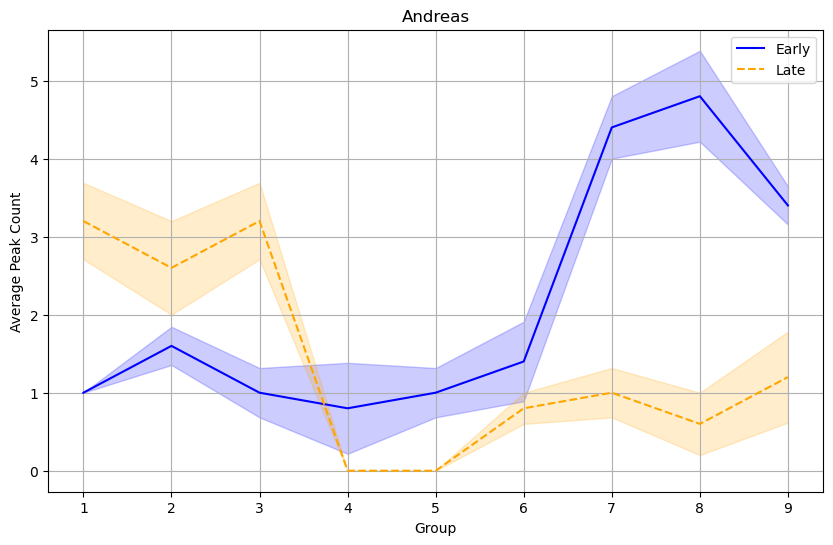

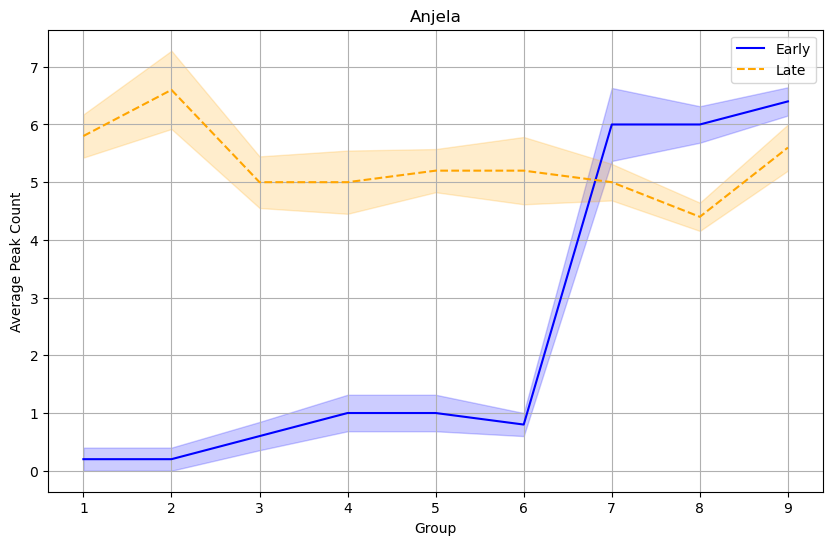

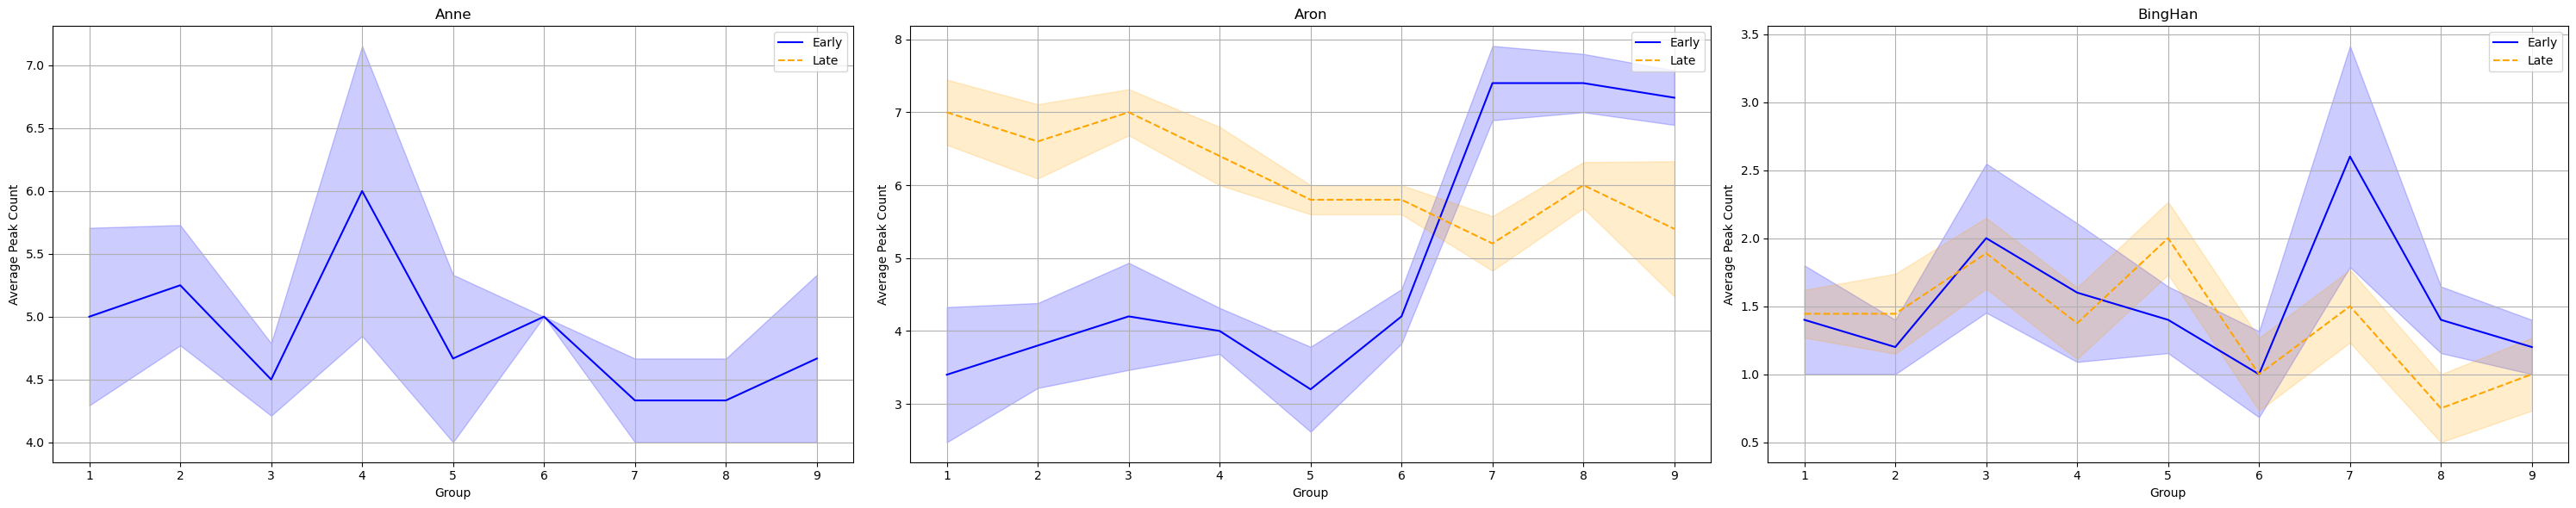

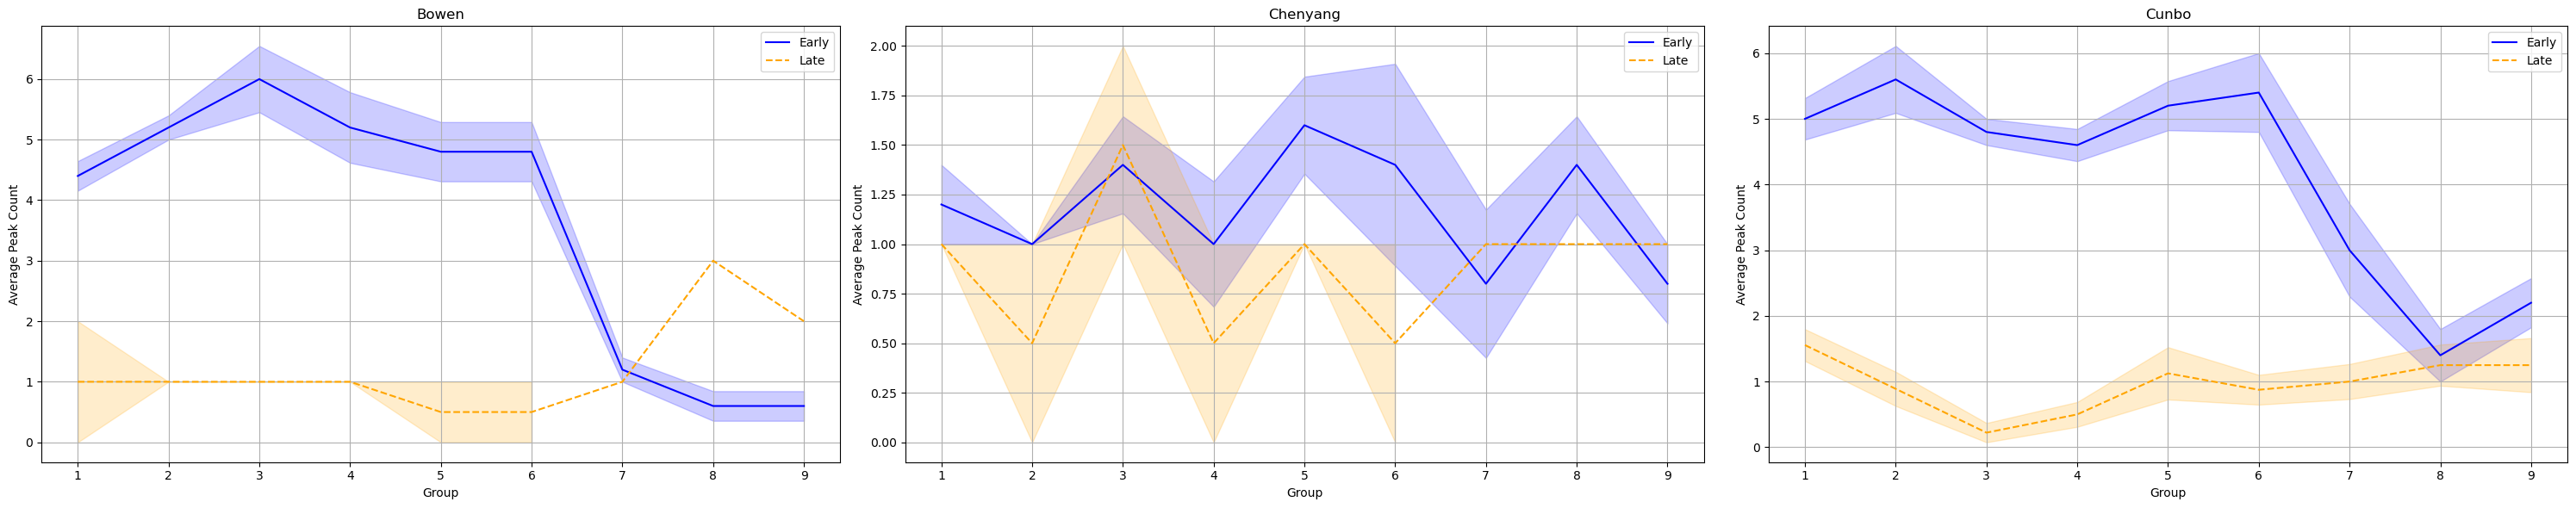

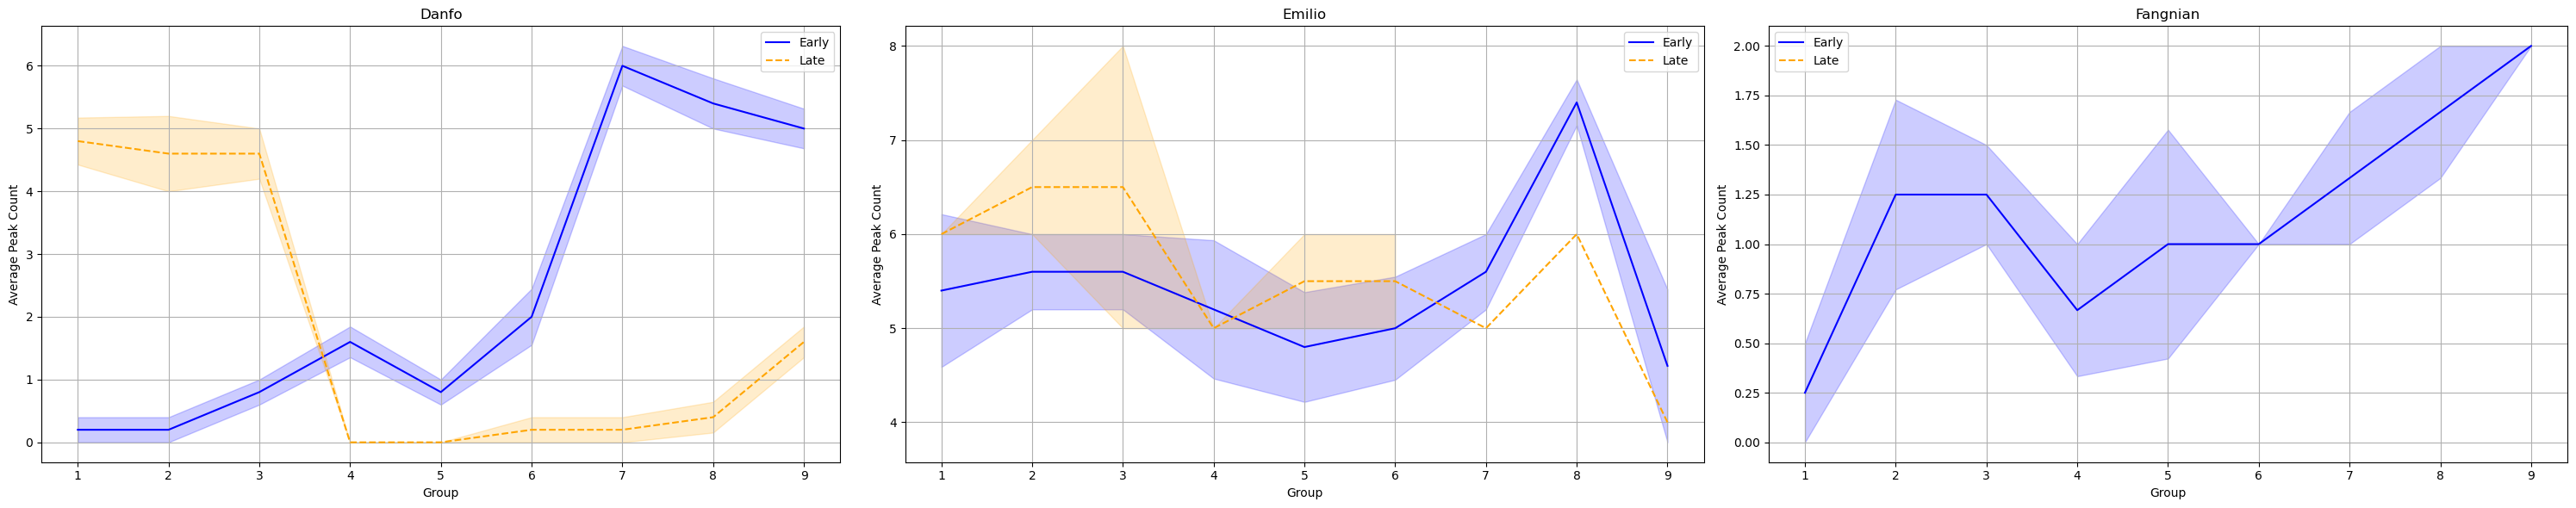

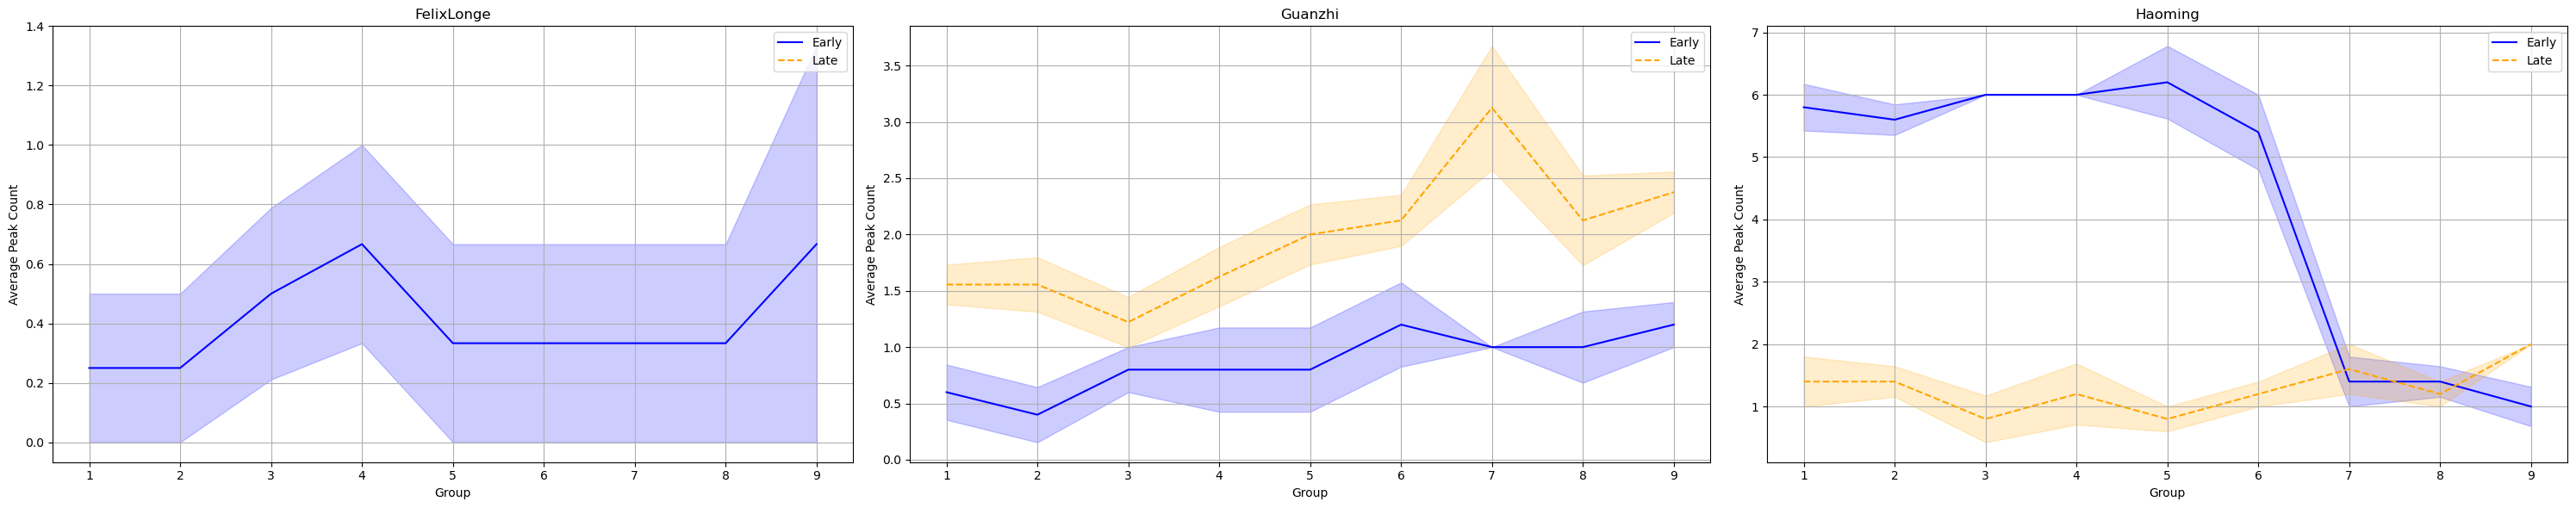

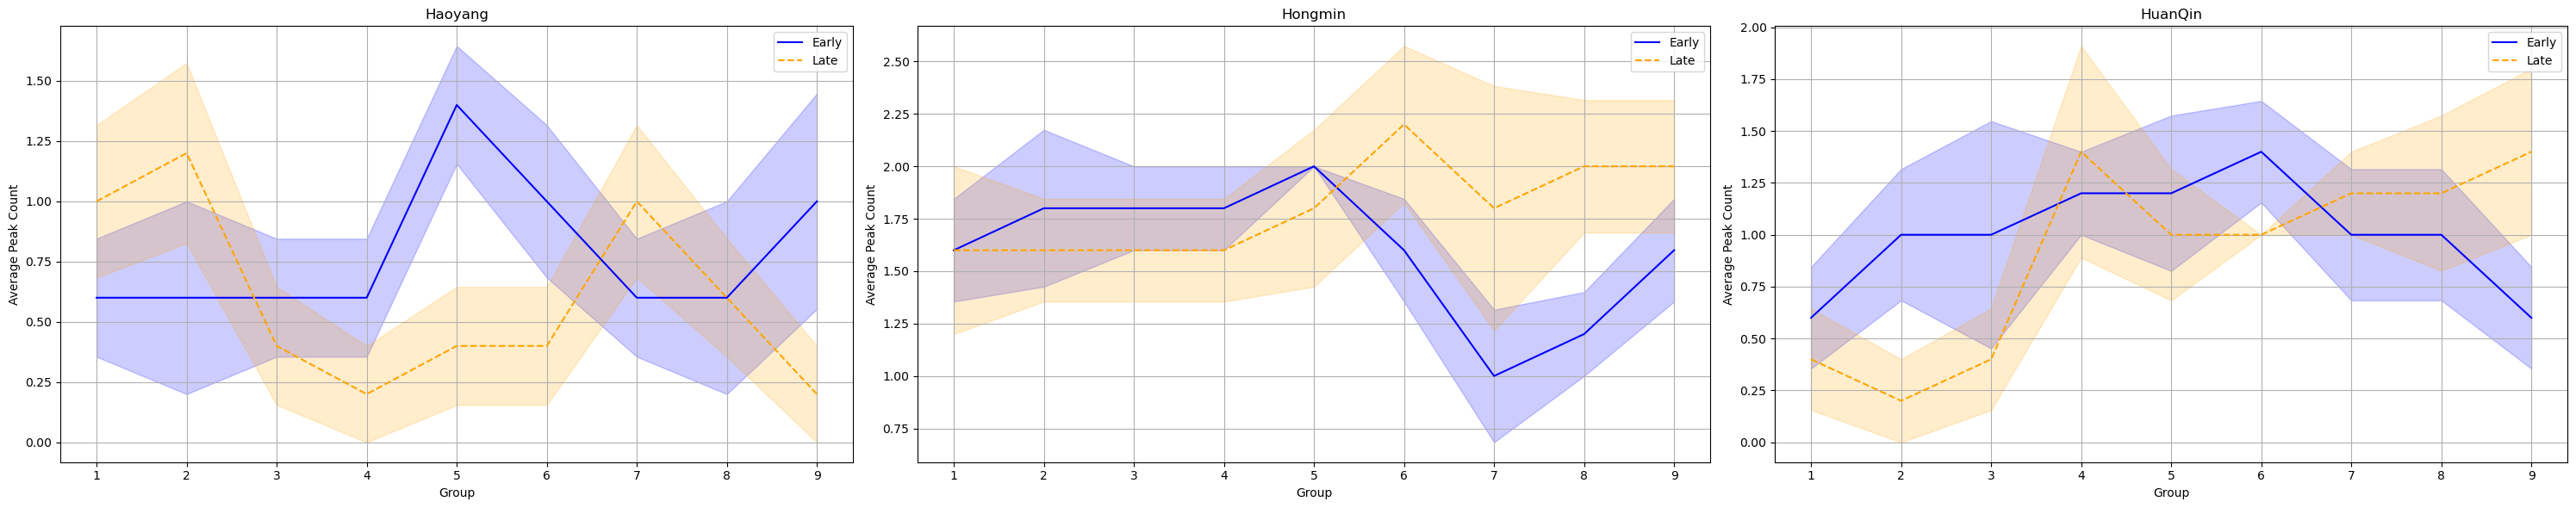

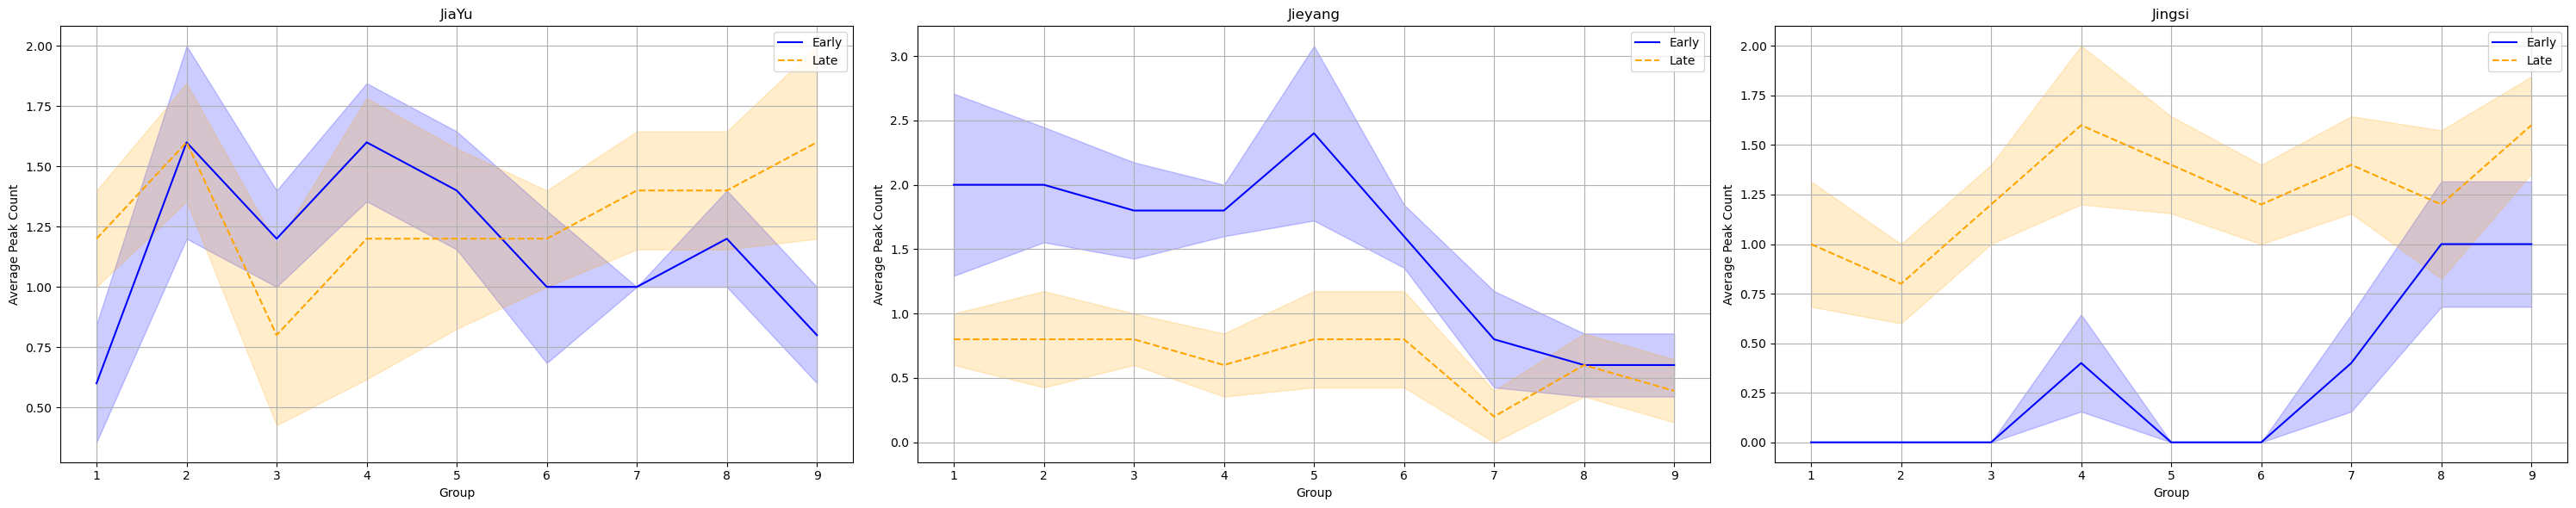

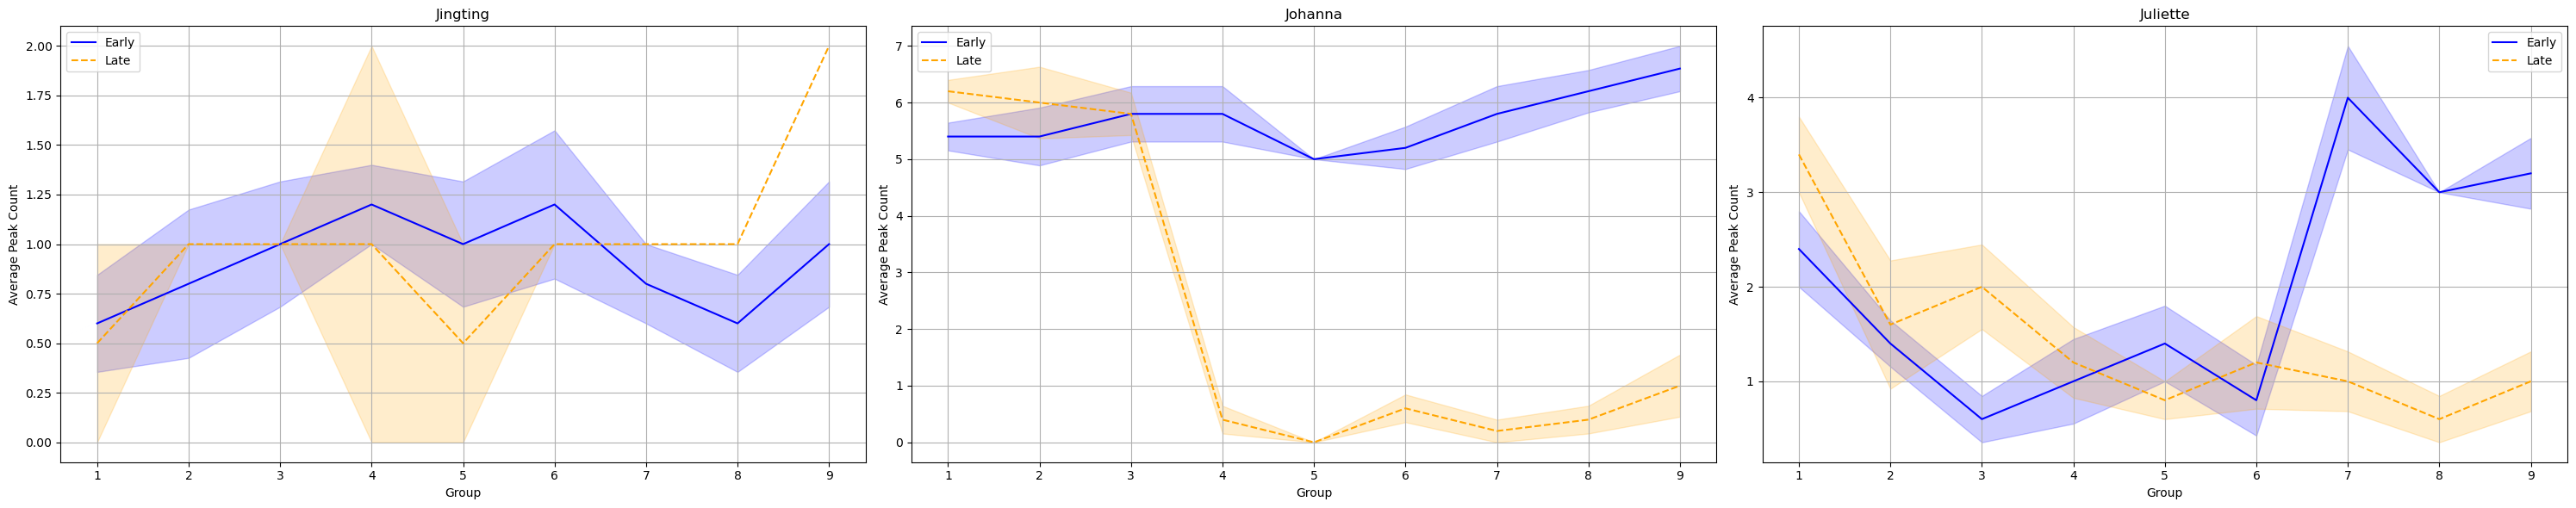

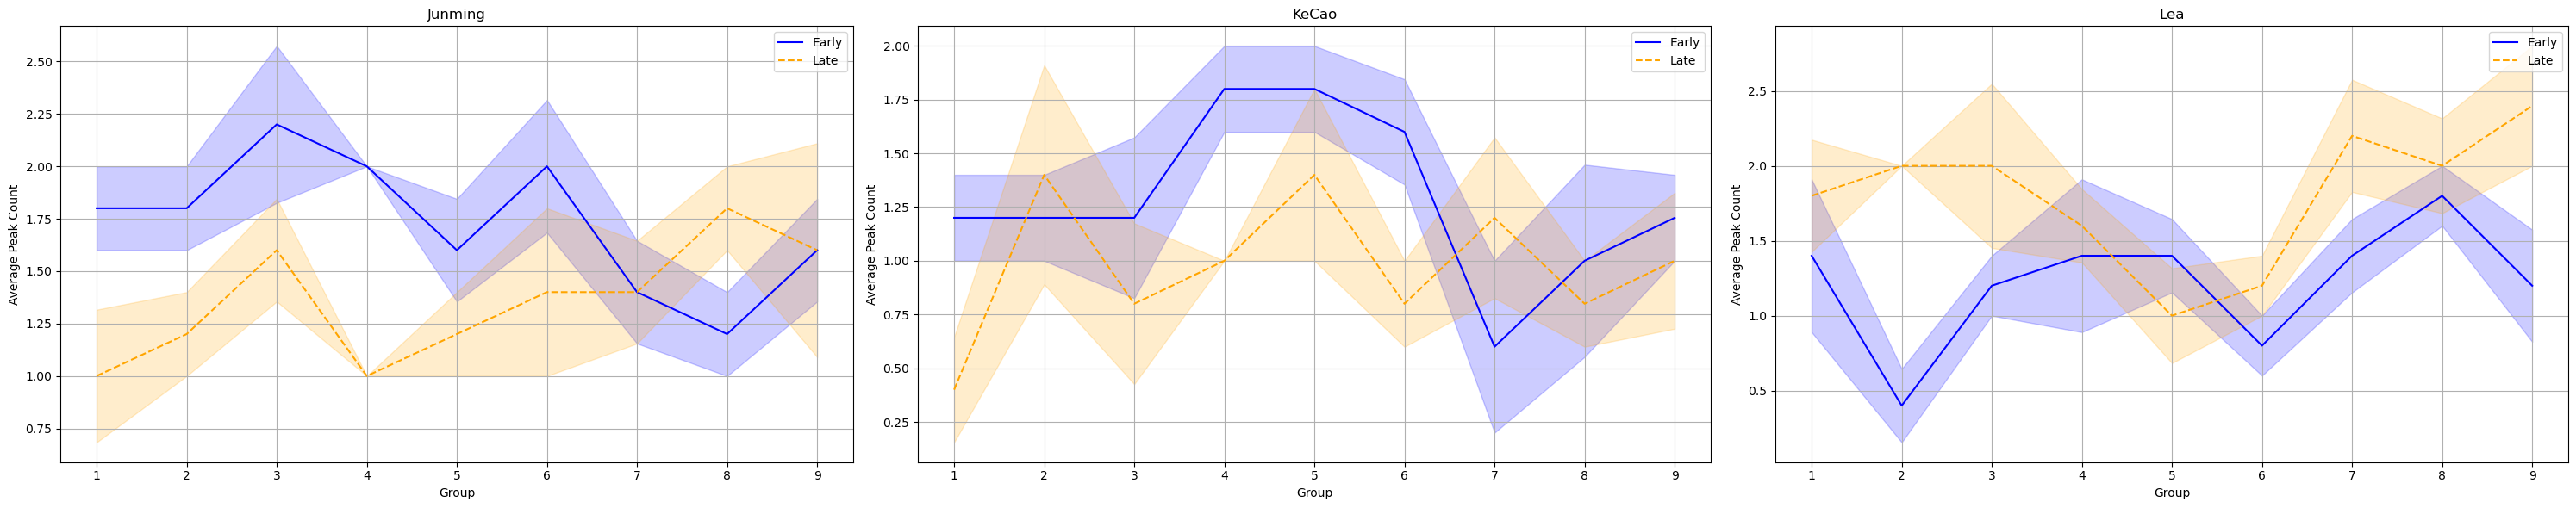

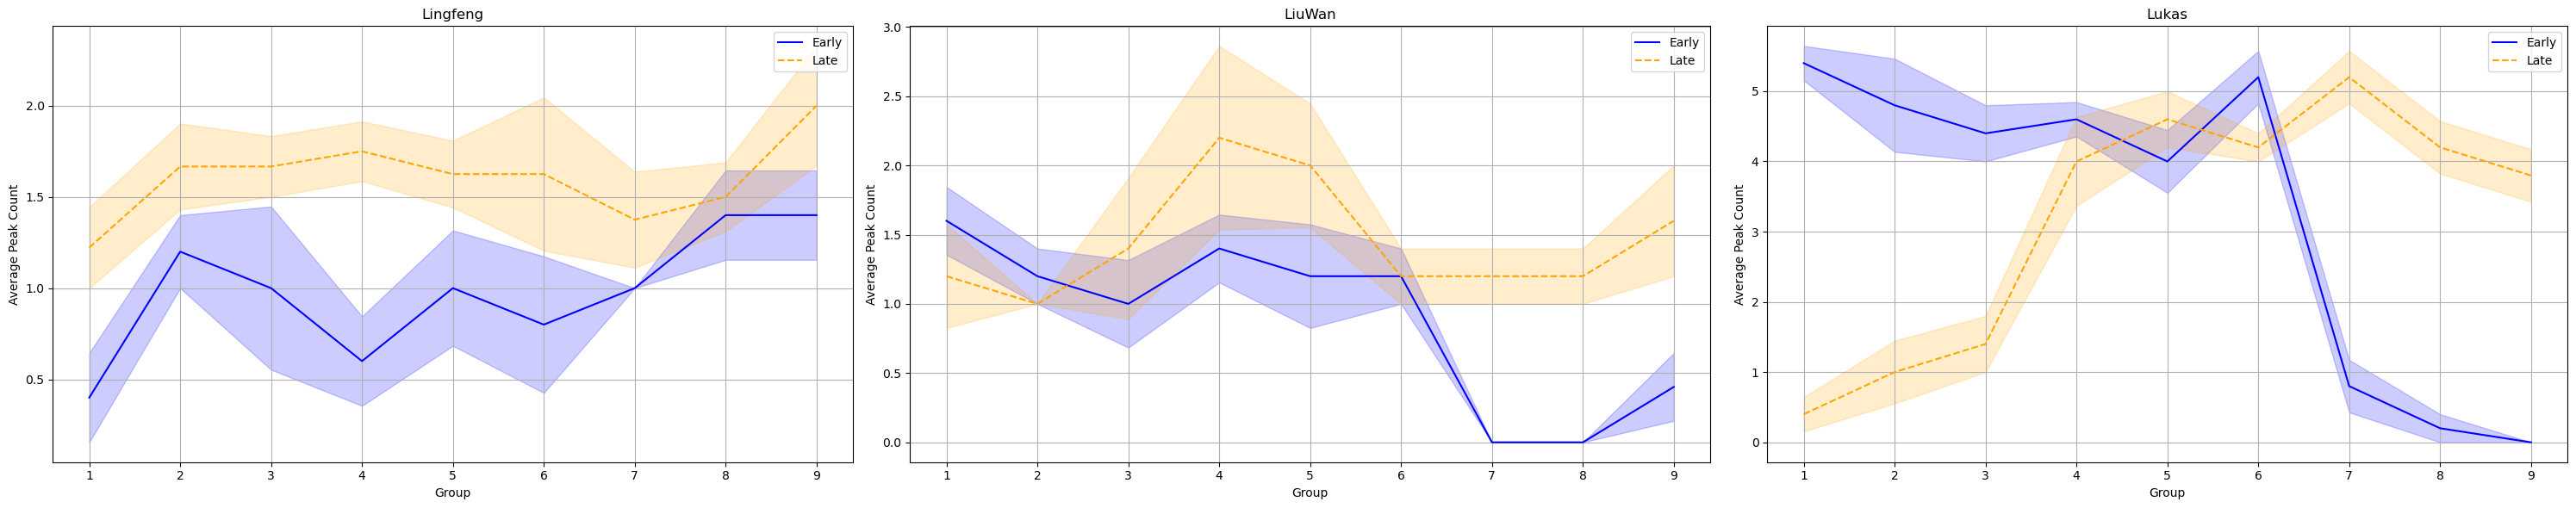

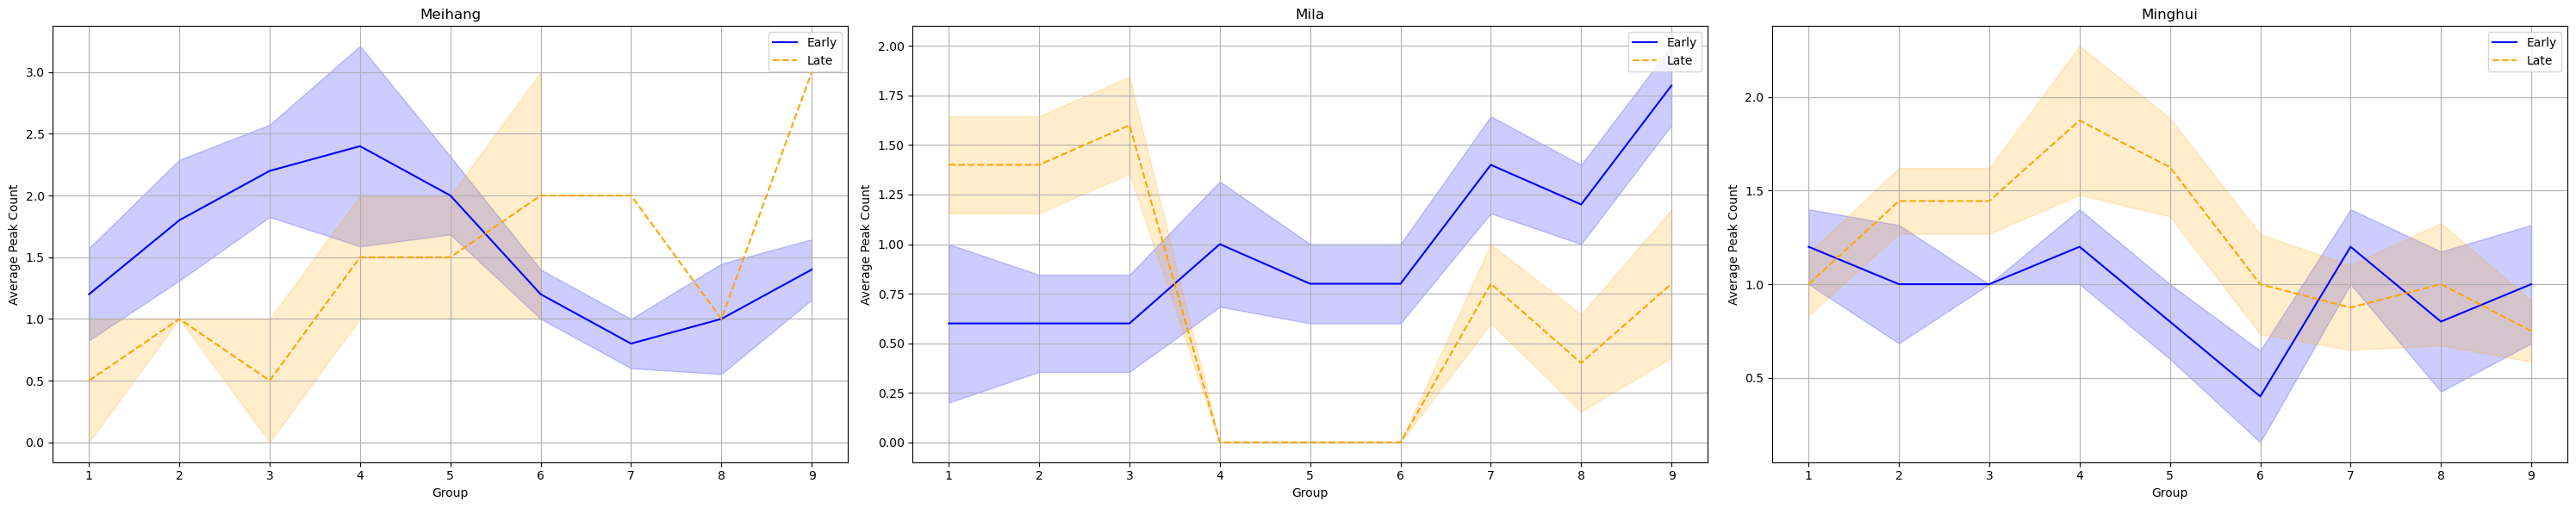

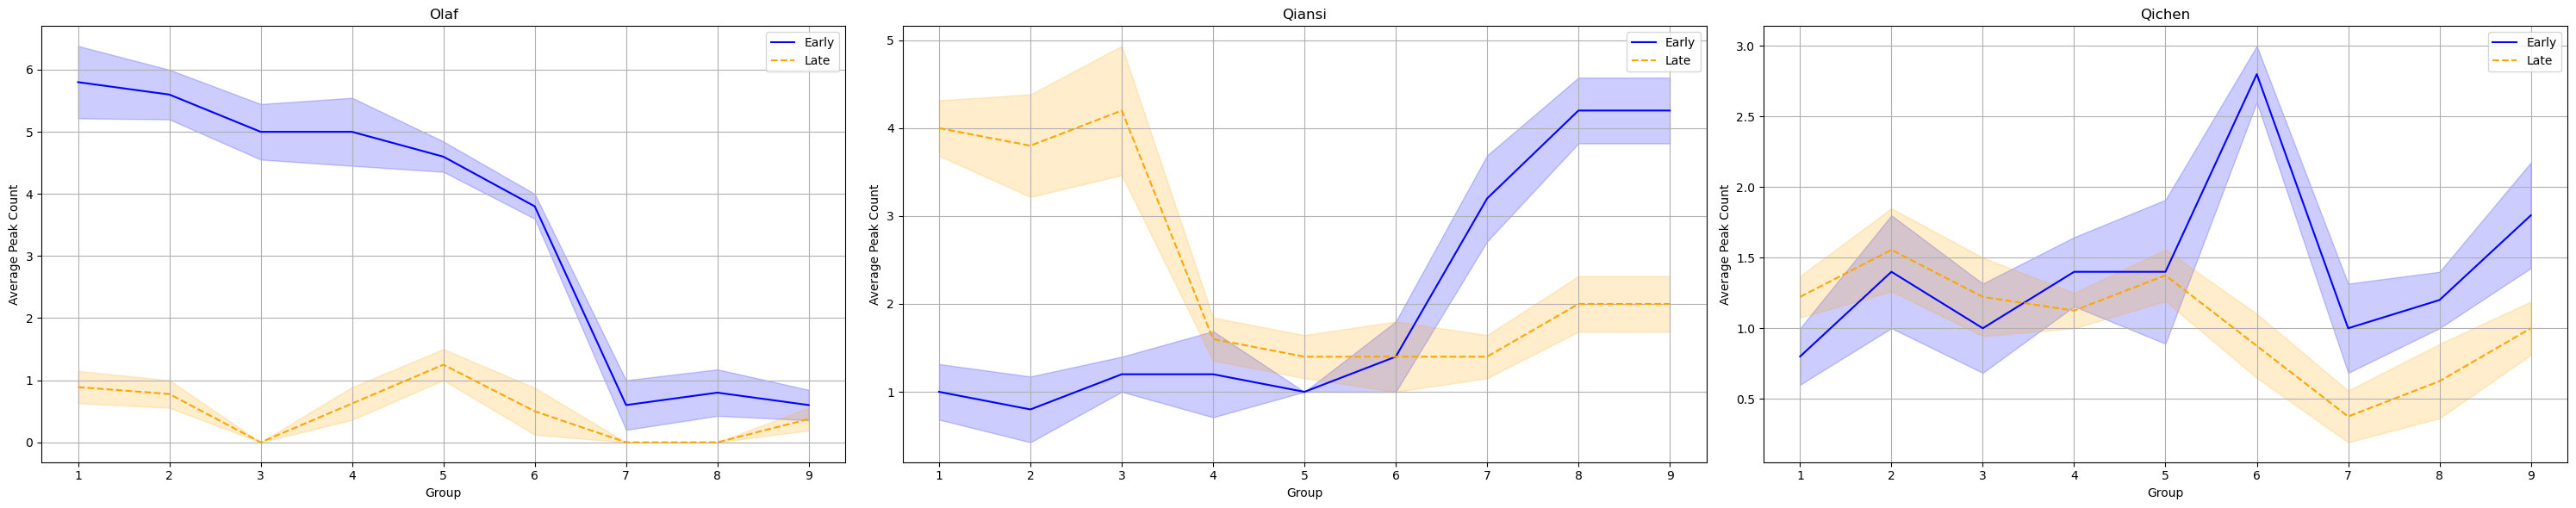

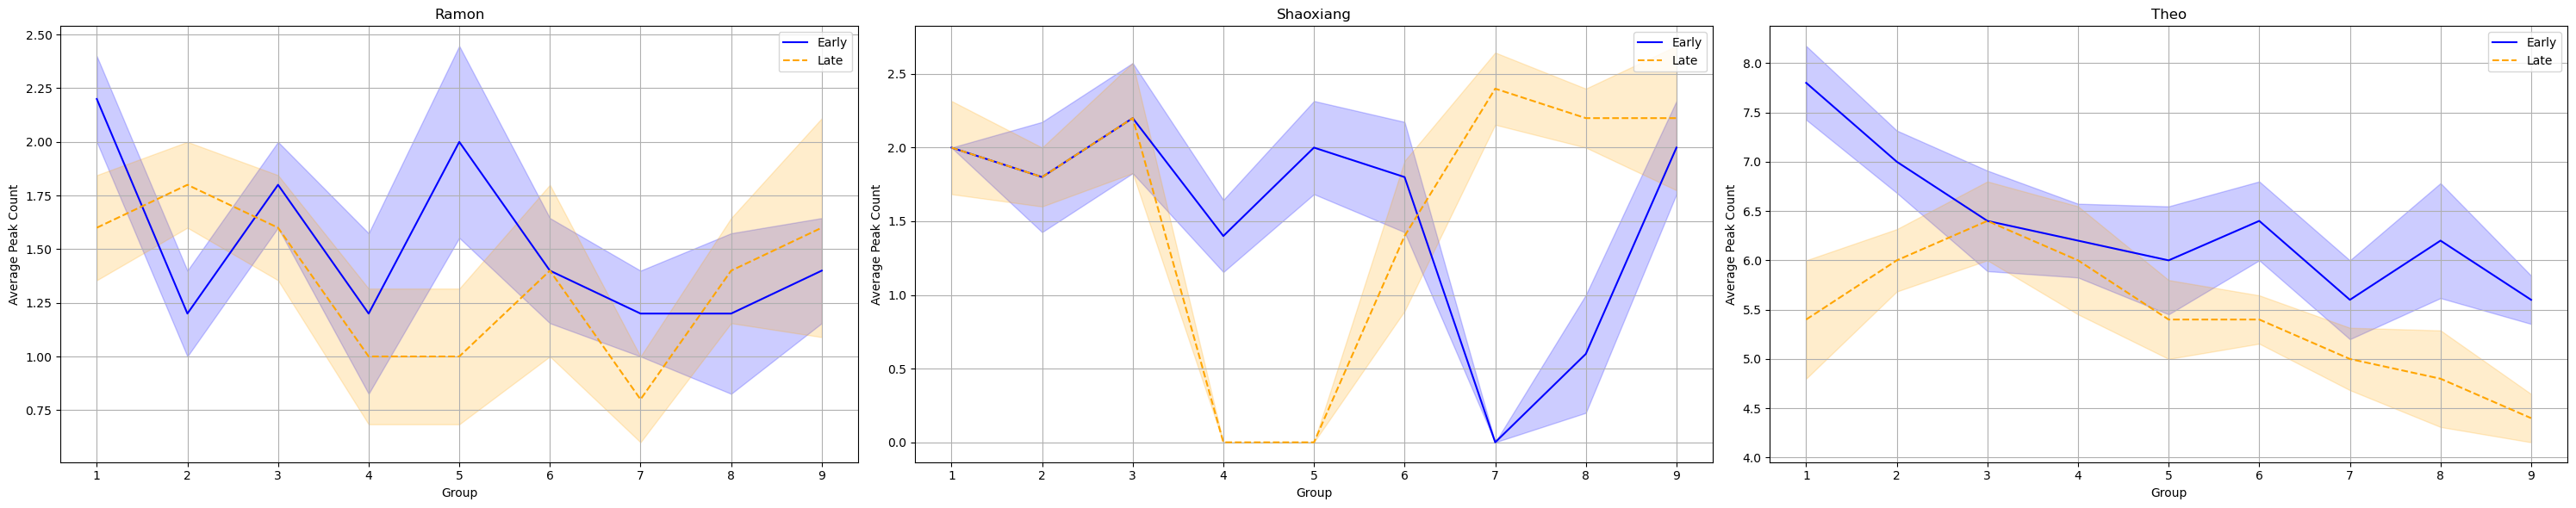

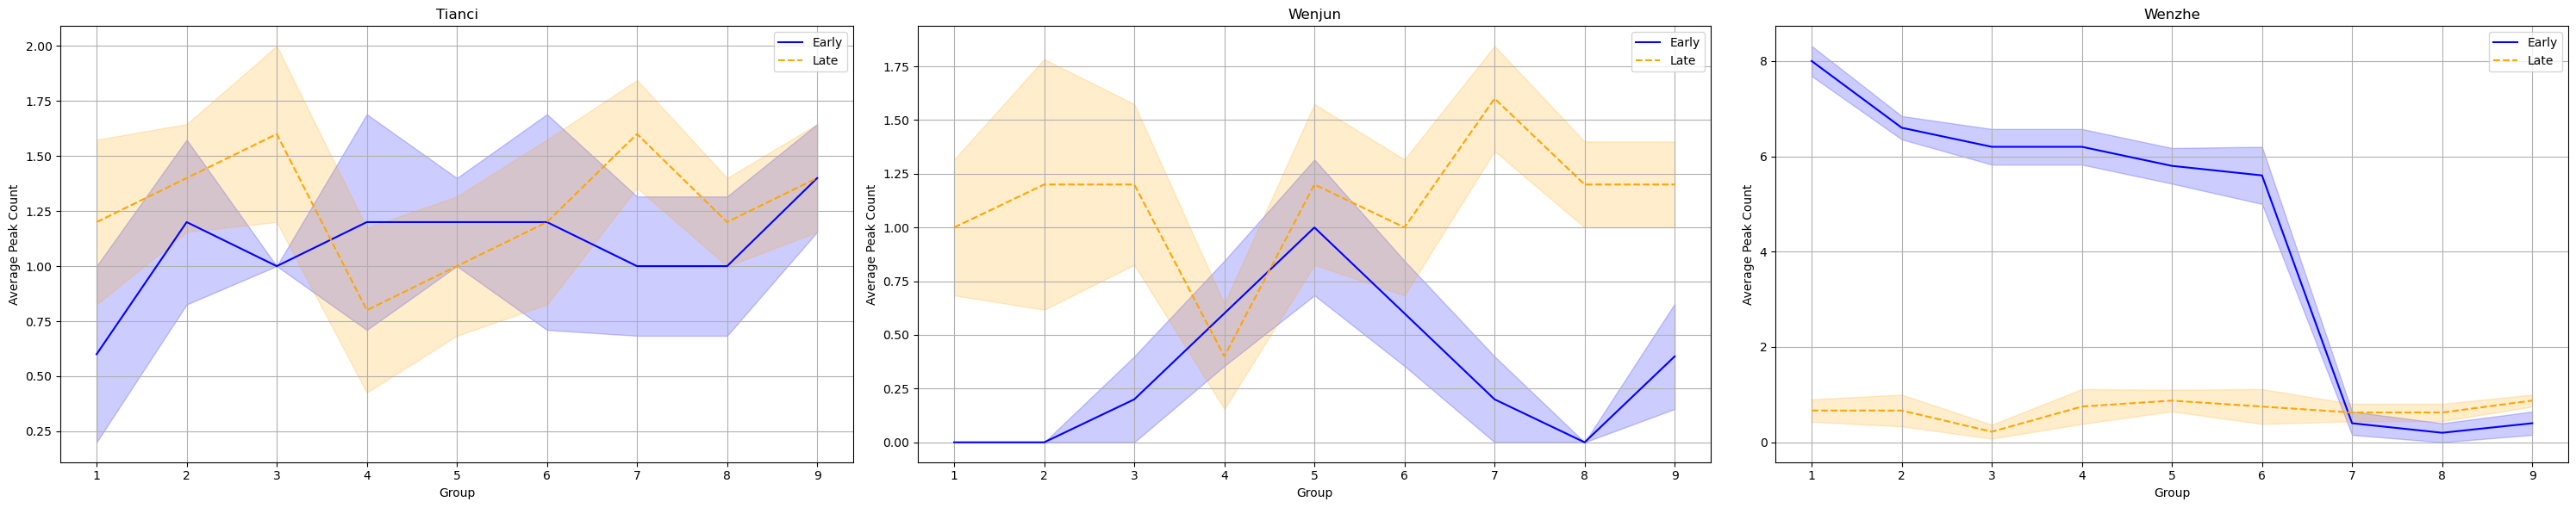

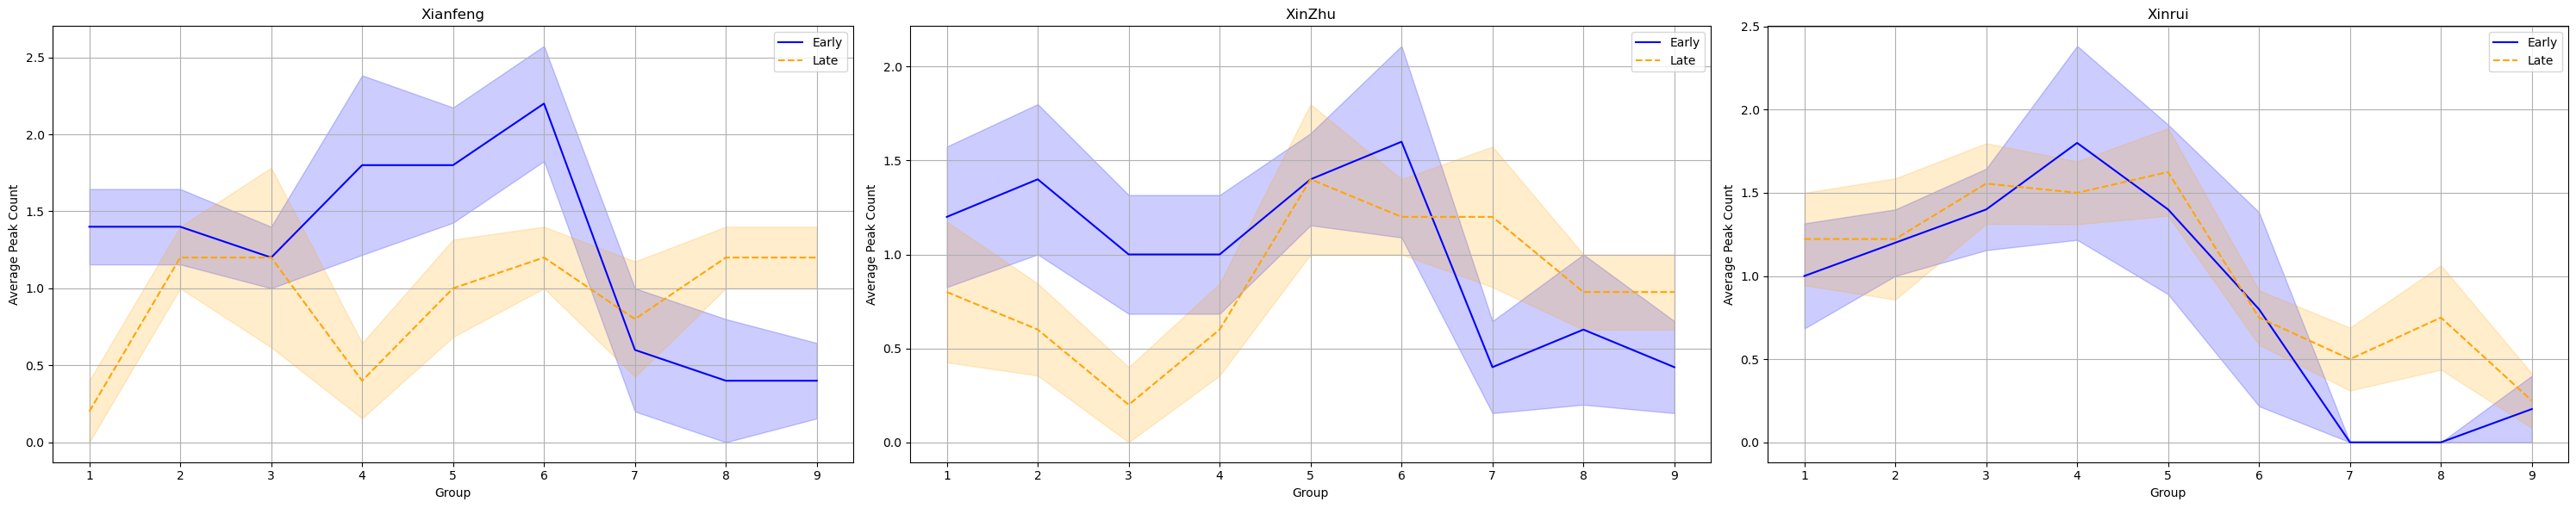

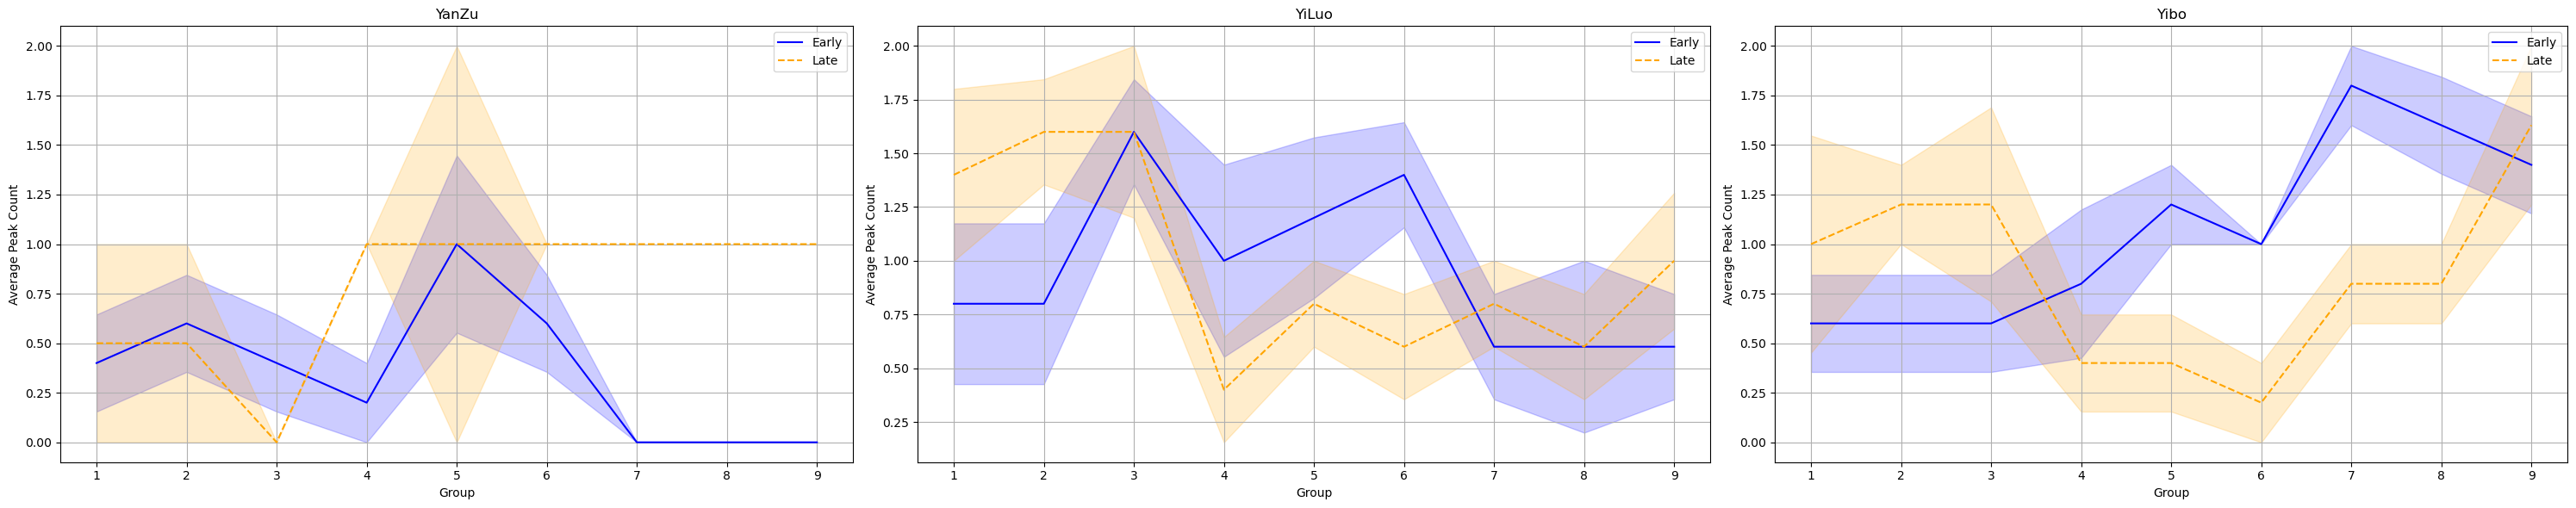

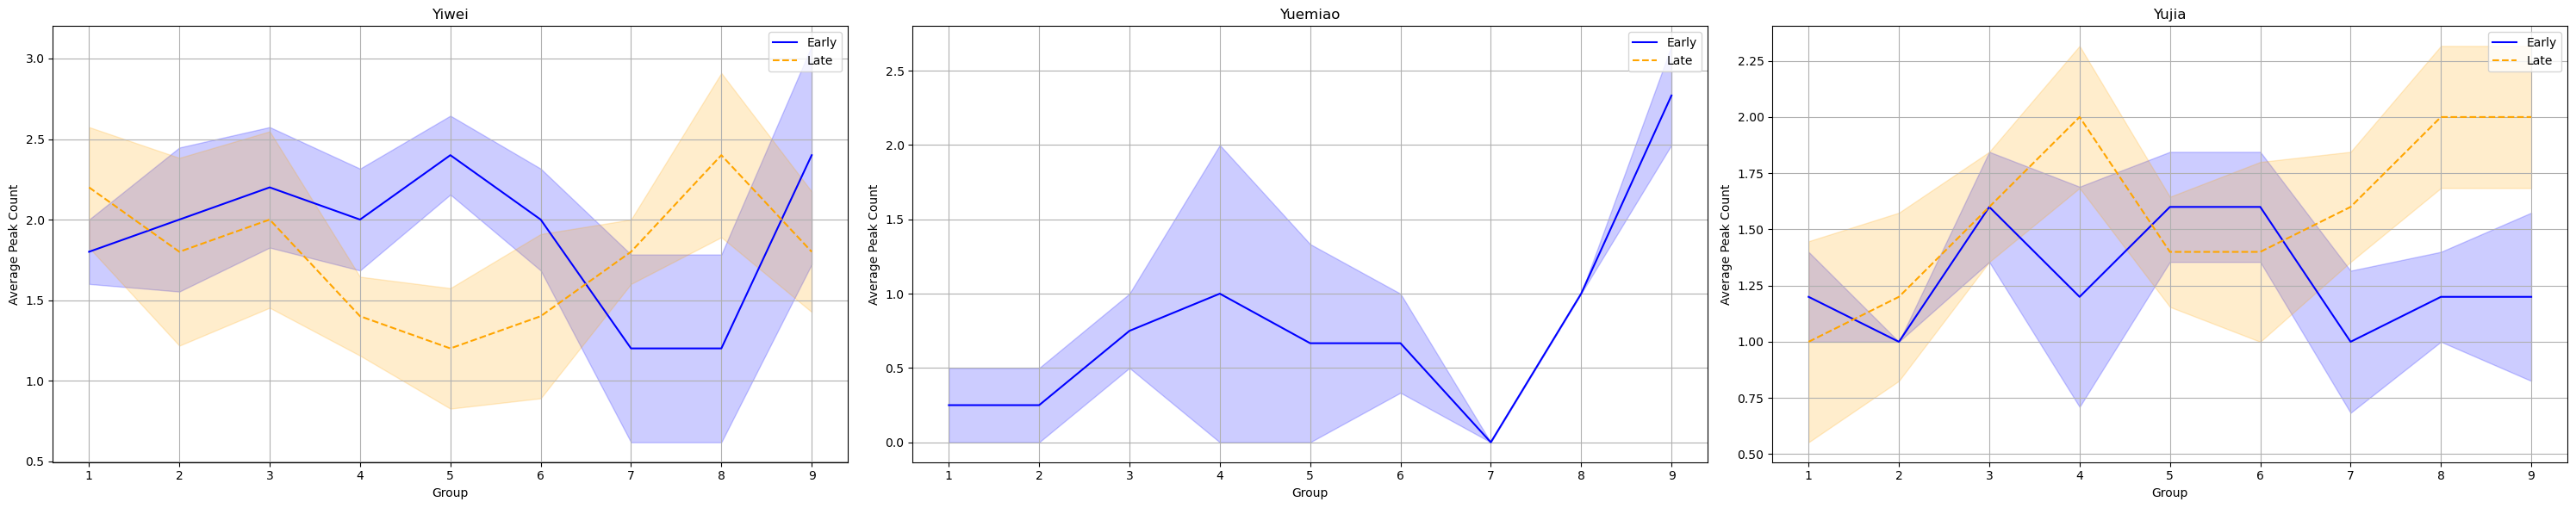

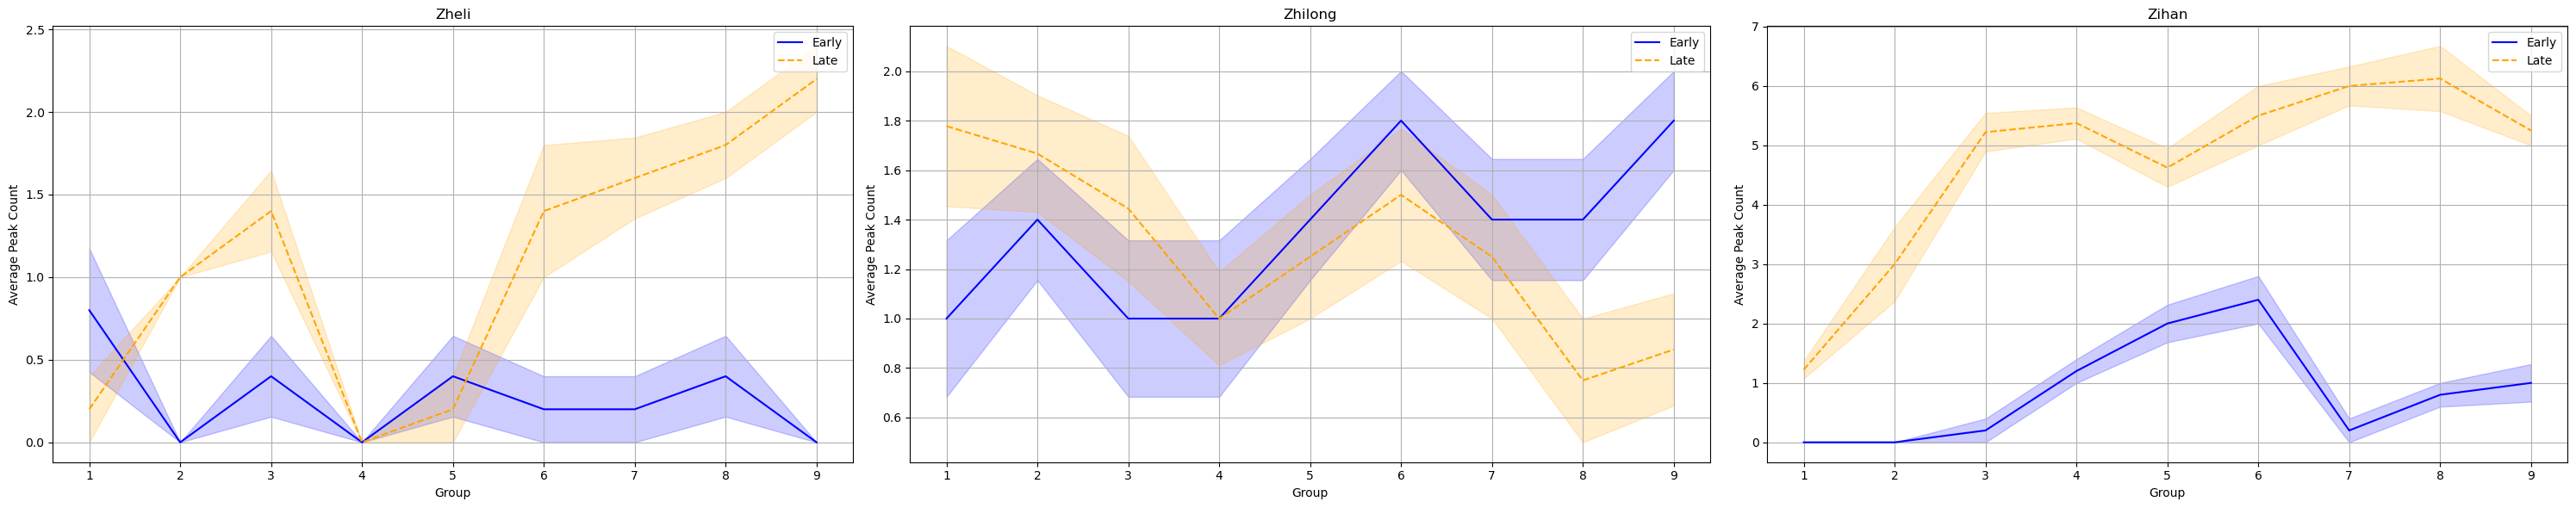

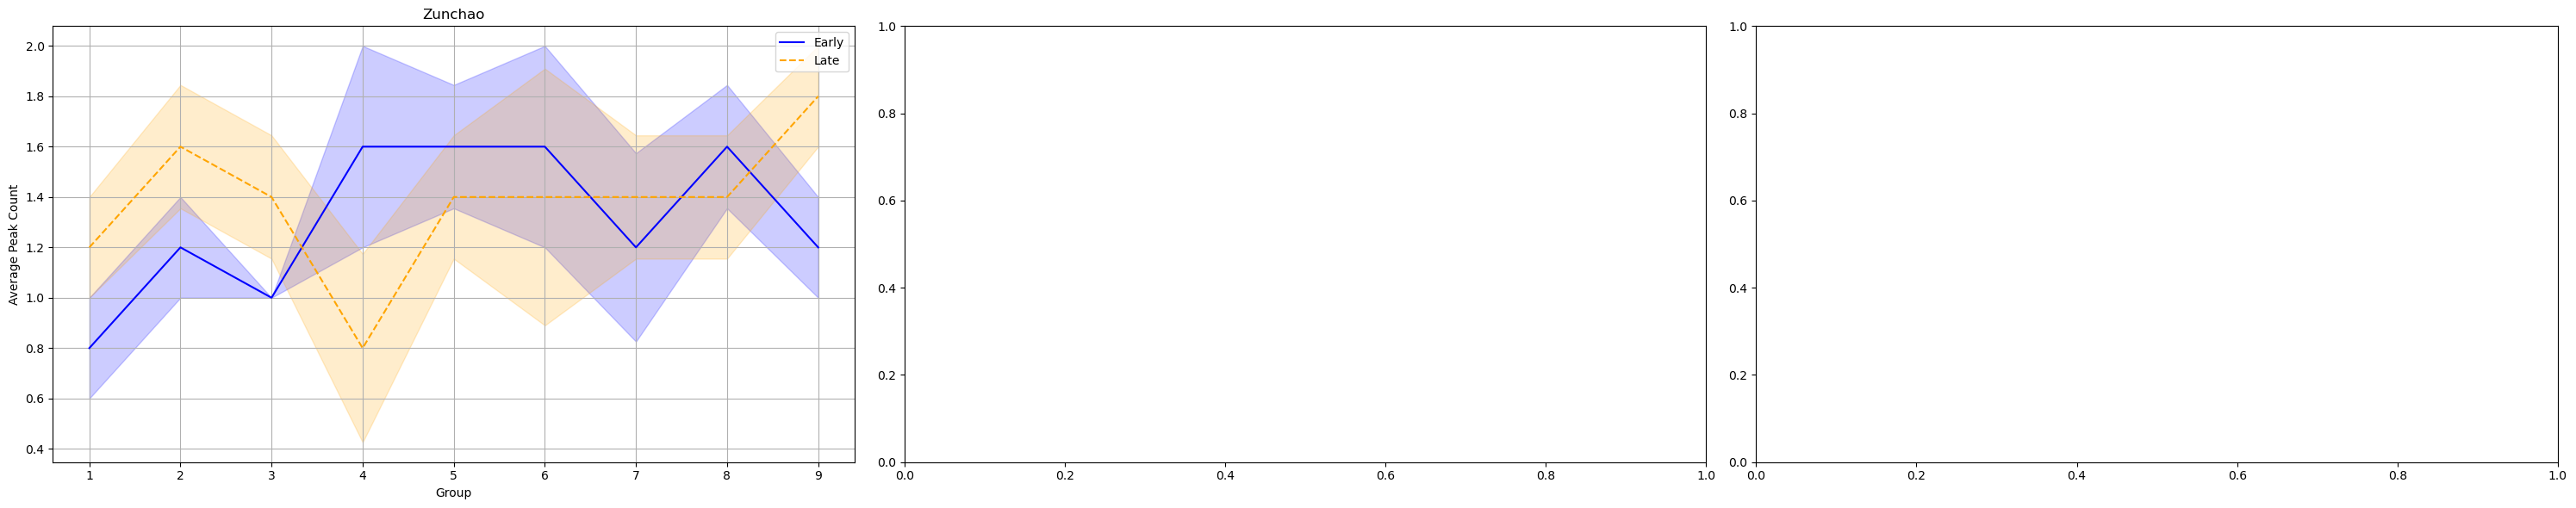

In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# 假设 df_output 包含所有受试者的数据

# 定义一个函数来生成图表并展示
def create_and_display_plot(ax, participant_data, participant_name):
    # 提取峰值数据
    peaks = np.array(participant_data['peaks'].iloc[0])

    # 分成前45组和后45组
    early_peaks = peaks[:45]
    late_peaks = peaks[45:]

    # 将45组数据分成9小组，每组5个数据点
    def split_into_bins(peaks, num_bins=9):
        bins = np.array_split(peaks, num_bins)
        return bins

    early_bins = split_into_bins(early_peaks)
    late_bins = split_into_bins(late_peaks)

    # 计算每个小组的平均峰值数量和标准误
    def calculate_bin_means_and_se(bins):
        means = []
        ses = []
        for bin in bins:
            if len(bin) > 0:  # 确保bin中有数据
                concatenated_bin = np.concatenate(bin)
                means.append(np.mean(concatenated_bin))
                ses.append(sem(concatenated_bin))
            else:
                means.append(np.nan)
                ses.append(np.nan)
        return means, ses

    early_means, early_ses = calculate_bin_means_and_se(early_bins)
    late_means, late_ses = calculate_bin_means_and_se(late_bins)

    # 创建数据框以便于绘图
    data = {
        'Phase': ['Early']*9 + ['Late']*9,
        'Group': list(range(1, 10)) + list(range(1, 10)),
        'Mean Peak Count': early_means + late_means,
        'SE': early_ses + late_ses
    }
    df = pd.DataFrame(data)

    # 在提供的轴上绘制图表
    # 早期数据
    ax.plot(df[df['Phase'] == 'Early']['Group'], 
             df[df['Phase'] == 'Early']['Mean Peak Count'], 
             label='Early', color='blue')
    ax.fill_between(df[df['Phase'] == 'Early']['Group'], 
                     df[df['Phase'] == 'Early']['Mean Peak Count'] - df[df['Phase'] == 'Early']['SE'],
                     df[df['Phase'] == 'Early']['Mean Peak Count'] + df[df['Phase'] == 'Early']['SE'],
                     color='blue', alpha=0.2)

    # 晚期数据
    ax.plot(df[df['Phase'] == 'Late']['Group'], 
             df[df['Phase'] == 'Late']['Mean Peak Count'], 
             label='Late', color='orange', linestyle='--')
    ax.fill_between(df[df['Phase'] == 'Late']['Group'], 
                     df[df['Phase'] == 'Late']['Mean Peak Count'] - df[df['Phase'] == 'Late']['SE'],
                     df[df['Phase'] == 'Late']['Mean Peak Count'] + df[df['Phase'] == 'Late']['SE'],
                     color='orange', alpha=0.2)

    ax.set_xlabel('Group')
    ax.set_ylabel('Average Peak Count')
    ax.set_title(f'{participant_name}')
    ax.legend()
    ax.grid(True)

# 生成图表并展示
participants = df_output['tester'].unique()

# 保留前两个参与者的图表单独展示
for participant in participants[:2]:
    participant_data = df_output[df_output['tester'] == participant]
    fig, ax = plt.subplots(figsize=(10, 6))
    create_and_display_plot(ax, participant_data, participant)
    plt.show()

# 将后面的参与者分组，每三人一列展示
for i in range(2, len(participants), 3):
    fig, axs = plt.subplots(1, 3, figsize=(30, 6))
    for j, participant in enumerate(participants[i:i+3]):
        create_and_display_plot(axs[j], df_output[df_output['tester'] == participant], participant)
    
    plt.tight_layout()
    plt.show()
